In [117]:
pip install seaborn 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [119]:
cgm_dataframe = pd.read_csv('cgm_train.csv')
cgm_dataframe.head()

cgm_dataframe['Lunch Time'] = pd.to_datetime(cgm_dataframe['Lunch Time'], errors='coerce')
cgm_dataframe['Lunch Time']= cgm_dataframe['Lunch Time'].dt.time
valid_times = cgm_dataframe['Lunch Time'].dropna()
valid_seconds = [t.hour * 3600 + t.minute * 60 + t.second for t in valid_times]
avg_seconds = int(np.mean(valid_seconds))
avg_time = pd.to_datetime(avg_seconds, unit='s').time()
cgm_dataframe['Lunch Time'] = cgm_dataframe['Lunch Time'].fillna(avg_time)

In [120]:
import ast

cgm_dataframe['CGM Data'] = cgm_dataframe['CGM Data'].apply(ast.literal_eval)

In [121]:
cgm_dataframe=cgm_dataframe.drop(['Breakfast Time'],axis=1)

In [122]:
cgm_dataframe = cgm_dataframe[cgm_dataframe['CGM Data'].apply(lambda x: len(x) > 0)]

In [123]:
print(cgm_dataframe.shape)

(319, 4)


In [124]:
from datetime import datetime
for index, row in cgm_dataframe.iterrows():
    cgm_data_list = row['CGM Data']
    updated_cgm_data = [(datetime.strptime(item[0], "%Y-%m-%d %H:%M:%S").strftime("%H:%M:%S"), item[1]) for item in cgm_data_list]
    cgm_dataframe.at[index, 'CGM Data'] = updated_cgm_data
print(cgm_dataframe)

     Subject ID  Day Lunch Time  \
0             1    2   12:24:00   
1             1    3   15:20:00   
2             1    4   13:09:00   
3             1    5   13:50:00   
4             1    6   13:17:00   
..          ...  ...        ...   
319           7    6   12:28:00   
320           7    7   13:13:00   
321           7    8   12:46:00   
322           7    9   12:38:00   
323           7   10   12:34:00   

                                              CGM Data  
0    [(08:20:00, 98.26666666666667), (08:30:00, 97....  
1    [(09:10:00, 97.18333333333334), (09:15:00, 98....  
2    [(09:20:00, 107.36666666666666), (09:25:00, 10...  
3    [(09:25:00, 107.28333333333333), (09:30:00, 11...  
4    [(08:55:00, 103.0), (09:00:00, 103.55), (09:05...  
..                                                 ...  
319  [(08:50:00, 101.36), (08:55:00, 104.04), (09:0...  
320  [(08:40:00, 100.68), (08:45:00, 104.4), (08:50...  
321  [(09:00:00, 104.04), (09:05:00, 105.0), (09:10...  
322  [(08

In [125]:
from datetime import datetime, timedelta
for index, row in cgm_dataframe.iterrows():
    cgm_data_list = row['CGM Data']
    updated_cgm_data = []
    for i in range(len(cgm_data_list)):
        time_str, value = cgm_data_list[i]
        time = datetime.strptime(time_str, "%H:%M:%S").time()
        updated_cgm_data.append((time, value))
    new_cgm_data = []
    if len(updated_cgm_data) > 0 :
      current_time = updated_cgm_data[0][0]
      current_value = updated_cgm_data[0][1]
      new_cgm_data.append((current_time, current_value))
      for i in range(1,len(updated_cgm_data)):
          next_time = updated_cgm_data[i][0]
          next_value = updated_cgm_data[i][1]
          time_diff = timedelta(hours=next_time.hour, minutes=next_time.minute, seconds=next_time.second) - timedelta(hours=current_time.hour, minutes=current_time.minute, seconds=current_time.second)
          if time_diff >= timedelta(minutes=5):
              while time_diff >= timedelta(minutes=5):
                  current_time = (datetime.combine(datetime.today(), current_time) + timedelta(minutes=5)).time()
                  avg_val = (current_value + next_value)/2
                  new_cgm_data.append((current_time, avg_val))
                  time_diff -= timedelta(minutes=5)
          new_cgm_data.append((next_time,next_value))
          current_time = next_time
          current_value = next_value

      cgm_dataframe.at[index, 'CGM Data'] = new_cgm_data
cgm_dataframe

,Subject ID,Day,Lunch Time,CGM Data
0,1,2,12:24:00,"[(08:20:00, 98.26666666666667), (08:25:00, 97...."
1,1,3,15:20:00,"[(09:10:00, 97.18333333333334), (09:15:00, 97...."
2,1,4,13:09:00,"[(09:20:00, 107.36666666666666), (09:25:00, 10..."
3,1,5,13:50:00,"[(09:25:00, 107.28333333333333), (09:30:00, 11..."
4,1,6,13:17:00,"[(08:55:00, 103.0), (09:00:00, 103.275), (09:0..."
...,...,...,...,...
319,7,6,12:28:00,"[(08:50:00, 101.36), (08:55:00, 102.7), (08:55..."
320,7,7,13:13:00,"[(08:40:00, 100.68), (08:45:00, 102.54), (08:4..."
321,7,8,12:46:00,"[(09:00:00, 104.04), (09:05:00, 104.5200000000..."
322,7,9,12:38:00,"[(08:25:00, 96.4), (08:30:00, 98.56), (08:30:0..."


In [126]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
for index, row in cgm_dataframe.iterrows():
    lunch_time = row['Lunch Time']
    cgm_data_list = row['CGM Data']
    rounded_lunch_time = (datetime.combine(datetime.today(), lunch_time) +
                          timedelta(minutes=5 - lunch_time.minute % 5)).time()
    post_lunch_cgm = []
    for time_str, value in cgm_data_list:
        if isinstance(time_str, str):
            time = datetime.strptime(time_str, "%H:%M:%S").time()
        else:
            time = time_str

        if time >= rounded_lunch_time:
            post_lunch_cgm.append((time, value))
    if not post_lunch_cgm:
        post_lunch_cgm = cgm_data_list[-13:]
    cgm_values = [value for _, value in post_lunch_cgm]
    cgm_diff = np.diff(cgm_values).tolist()
    while len(cgm_diff) < 12:
        cgm_diff.append(np.nan)
    cgm_features = {}
    for i in range(12):
        cgm_features[f'cgm_diff{i+1}'] = cgm_diff[i]
    if len(cgm_diff) > 0 and not all(np.isnan(cgm_diff)):
        diff_mean = np.nanmean(cgm_diff)
        diff_max = np.nanmax(cgm_diff)
        diff_min = np.nanmin(cgm_diff)
        diff_std = np.nanstd(cgm_diff)
        diff_median = np.nanmedian(cgm_diff)
        diff_range = diff_max - diff_min
        diff_iqr = np.percentile(cgm_diff, 75) - np.percentile(cgm_diff, 25)
        diff_variance = np.nanvar(cgm_diff)
    else:
        diff_mean = diff_max = diff_min = diff_std = diff_median = diff_range = diff_iqr = diff_variance = np.nan
    for feature_name, feature_value in cgm_features.items():
        cgm_dataframe.loc[index, feature_name] = feature_value
    cgm_dataframe.loc[index, 'diff_mean'] = diff_mean
    cgm_dataframe.loc[index, 'diff_max'] = diff_max
    cgm_dataframe.loc[index, 'diff_min'] = diff_min
    cgm_dataframe.loc[index, 'diff_std'] = diff_std
    cgm_dataframe.loc[index, 'diff_median'] = diff_median
    cgm_dataframe.loc[index, 'diff_range'] = diff_range
    cgm_dataframe.loc[index, 'diff_iqr'] = diff_iqr
    cgm_dataframe.loc[index, 'diff_variance'] = diff_variance
from scipy.signal import find_peaks
from scipy.integrate import simps
for index, row in cgm_dataframe.iterrows():
    lunch_time = row['Lunch Time']
    cgm_data_list = row['CGM Data']
    rounded_lunch_time = (datetime.combine(datetime.today(), lunch_time) +
                          timedelta(minutes=5 - lunch_time.minute % 5)).time()
    post_lunch_cgm = []
    for time_str, value in cgm_data_list:
        if isinstance(time_str, str):
            time = datetime.strptime(time_str, "%H:%M:%S").time()
        else:
            time = time_str
        if time >= rounded_lunch_time:
            post_lunch_cgm.append((time, value))
    if not post_lunch_cgm:
        post_lunch_cgm = cgm_data_list[-13:]
    cgm_values = [value for _, value in post_lunch_cgm]
    cgm_diff = np.diff(cgm_values).tolist()
    while len(cgm_diff) < 12:
        cgm_diff.append(np.nan)
    cgm_features = {}
    for i in range(12):
        cgm_features[f'cgm_diff{i+1}'] = cgm_diff[i]
    if len(cgm_diff) > 0 and not all(np.isnan(cgm_diff)):
        diff_mean = np.nanmean(cgm_diff)
        diff_max = np.nanmax(cgm_diff)
        diff_min = np.nanmin(cgm_diff)
        diff_std = np.nanstd(cgm_diff)
        diff_median = np.nanmedian(cgm_diff)
        diff_range = diff_max - diff_min
        diff_iqr = np.percentile(cgm_diff, 75) - np.percentile(cgm_diff, 25)
        diff_variance = np.nanvar(cgm_diff)
    else:
        diff_mean = diff_max = diff_min = diff_std = diff_median = diff_range = diff_iqr = diff_variance = np.nan
    if post_lunch_cgm:
        times = [datetime.strptime(str(t), "%H:%M:%S").time() for t, _ in post_lunch_cgm]
        values = [v for _, v in post_lunch_cgm]
        time_to_peak = (datetime.combine(datetime.today(), max(times)) -
                        datetime.combine(datetime.today(), rounded_lunch_time)).seconds / 60.0
        time_to_trough = (datetime.combine(datetime.today(), min(times)) -
                          datetime.combine(datetime.today(), rounded_lunch_time)).seconds / 60.0
    else:
        time_to_peak = time_to_trough = np.nan
    rate_of_change = np.gradient(cgm_values).tolist() if cgm_values else []
    max_rate_of_change = max(rate_of_change) if rate_of_change else np.nan
    min_rate_of_change = min(rate_of_change) if rate_of_change else np.nan
    peaks, _ = find_peaks(cgm_values)
    troughs, _ = find_peaks([-v for v in cgm_values])
    peak_count = len(peaks)
    trough_count = len(troughs)
    peak_to_peak_diff = max(cgm_values) - min(cgm_values) if cgm_values else np.nan
    auc = simps(cgm_values) if cgm_values else np.nan
    for feature_name, feature_value in cgm_features.items():
        cgm_dataframe.loc[index, feature_name] = feature_value

    cgm_dataframe.loc[index, 'diff_mean'] = diff_mean
    cgm_dataframe.loc[index, 'diff_max'] = diff_max
    cgm_dataframe.loc[index, 'diff_min'] = diff_min
    cgm_dataframe.loc[index, 'diff_std'] = diff_std
    cgm_dataframe.loc[index, 'diff_median'] = diff_median
    cgm_dataframe.loc[index, 'diff_range'] = diff_range
    cgm_dataframe.loc[index, 'diff_iqr'] = diff_iqr
    cgm_dataframe.loc[index, 'diff_variance'] = diff_variance
    cgm_dataframe.loc[index, 'time_to_peak'] = time_to_peak
    cgm_dataframe.loc[index, 'time_to_trough'] = time_to_trough
    cgm_dataframe.loc[index, 'max_rate_of_change'] = max_rate_of_change
    cgm_dataframe.loc[index, 'min_rate_of_change'] = min_rate_of_change
    cgm_dataframe.loc[index, 'peak_count'] = peak_count
    cgm_dataframe.loc[index, 'trough_count'] = trough_count
    cgm_dataframe.loc[index, 'peak_to_peak_diff'] = peak_to_peak_diff
    cgm_dataframe.loc[index, 'auc'] = auc
print(cgm_dataframe)

     Subject ID  Day Lunch Time  \
0             1    2   12:24:00   
1             1    3   15:20:00   
2             1    4   13:09:00   
3             1    5   13:50:00   
4             1    6   13:17:00   
..          ...  ...        ...   
319           7    6   12:28:00   
320           7    7   13:13:00   
321           7    8   12:46:00   
322           7    9   12:38:00   
323           7   10   12:34:00   

                                              CGM Data  cgm_diff1  cgm_diff2  \
0    [(08:20:00, 98.26666666666667), (08:25:00, 97....   2.908333   3.233333   
1    [(09:10:00, 97.18333333333334), (09:15:00, 97....   0.816667  -0.091667   
2    [(09:20:00, 107.36666666666666), (09:25:00, 10...  -2.591667  -2.725000   
3    [(09:25:00, 107.28333333333333), (09:30:00, 11...  -0.775000  -1.450000   
4    [(08:55:00, 103.0), (09:00:00, 103.275), (09:0...  -2.373333  -0.436667   
..                                                 ...        ...        ...   
319  [(08:50:00, 10

In [127]:
cgm_dataframe=cgm_dataframe.drop(['CGM Data'],axis=1)

In [128]:
cgm_dataframe['Lunch Time'] = cgm_dataframe['Lunch Time'].apply(lambda x: x.hour * 60 + x.minute)

In [129]:
cgm_dataframe.head()

,Subject ID,Day,Lunch Time,cgm_diff1,cgm_diff2,cgm_diff3,cgm_diff4,cgm_diff5,cgm_diff6,cgm_diff7,...,diff_iqr,diff_variance,time_to_peak,time_to_trough,max_rate_of_change,min_rate_of_change,peak_count,trough_count,peak_to_peak_diff,auc
0,1,2,744,2.908333,3.233333,3.233333,5.583333,5.583333,0.308333,0.308333,...,2.425000,18.908932,215.0,0.0,10.300000,-12.950000,6.0,6.0,92.433333,7373.630556
1,1,3,920,0.816667,-0.091667,-0.091667,-0.316667,-0.316667,0.591667,0.591667,...,1.541667,1.949988,210.0,0.0,2.858333,-4.133333,7.0,6.0,17.900000,8387.544444
2,1,4,789,-2.591667,-2.725000,-2.725000,-1.500000,-1.500000,-1.225000,-1.225000,...,1.816667,3.334564,230.0,0.0,5.000000,-2.816667,6.0,7.0,44.450000,10473.497222
3,1,5,830,-0.775000,-1.450000,-1.450000,0.816667,0.816667,-0.091667,-0.091667,...,0.908333,0.319021,205.0,0.0,0.908333,-1.450000,6.0,7.0,18.675000,7603.408333
4,1,6,797,-2.373333,-0.436667,-0.436667,0.405000,0.405000,-1.031667,-1.031667,...,1.610833,2.061952,185.0,0.0,4.278333,-2.500000,5.0,5.0,21.683333,7832.495833


In [130]:
cgm_dataframe.isnull().sum()

Subject ID            0
Day                   0
Lunch Time            0
cgm_diff1             0
cgm_diff2             0
cgm_diff3             0
cgm_diff4             0
cgm_diff5             0
cgm_diff6             0
cgm_diff7             0
cgm_diff8             0
cgm_diff9             0
cgm_diff10            0
cgm_diff11            0
cgm_diff12            0
diff_mean             0
diff_max              0
diff_min              0
diff_std              0
diff_median           0
diff_range            0
diff_iqr              0
diff_variance         0
time_to_peak          0
time_to_trough        0
max_rate_of_change    0
min_rate_of_change    0
peak_count            0
trough_count          0
peak_to_peak_diff     0
auc                   0
dtype: int64

In [131]:
print(cgm_dataframe.shape)

(319, 31)


In [132]:
demo_viome_dataframe = pd.read_csv('demo_viome_train.csv')
demo_viome_dataframe.head()


,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,1,27,0,133.8,65.00,Hispanic/Latino,1,5.4,91.0,2.5,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
1,2,49,1,169.2,62.00,Hispanic/Latino,1,5.5,93.0,14.8,61.0,181.0,91.0,90.0,78.0,12.0,2.0,3.398519,30.943704,"-9.395216776716872,-7.315438412832852,1.103724..."
2,3,59,1,157.0,64.00,Hispanic/Latino,3,6.5,118.0,17.4,154.0,190.0,74.0,116.0,90.0,31.0,2.6,5.069630,26.946045,"-11.007947281293239,-8.444134921199856,0.28806..."
3,5,51,1,172.0,62.50,Hispanic/Latino,3,6.6,144.0,12.9,392.0,269.0,38.0,231.0,157.0,78.0,7.1,4.586667,30.954496,"-6.21833166351615,-5.868646092839025,-6.612900..."
4,6,51,1,197.0,68.75,White,1,5.2,96.0,6.4,75.0,203.0,72.0,131.0,118.0,15.0,2.8,1.517037,29.300575,"-6.7953636871125,-6.50799421035929,-1.85678011..."


In [133]:
print(demo_viome_dataframe.shape)

(36, 20)


In [134]:
img_dataframe = pd.read_csv('img_train.csv')
img_dataframe.head()

,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch
0,1,2,0.0,10,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13..."
1,1,3,0.0,4,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9..."
2,1,4,0.0,5,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4..."
3,1,5,7.0,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2..."
4,1,6,0.0,18,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [..."


In [135]:
print(img_dataframe.isnull().sum())

Subject ID                0
Day                       0
Breakfast Fiber           2
Lunch Fiber               0
Image Before Breakfast    0
Image Before Lunch        0
dtype: int64


In [136]:
mean_fiber_breakfast = img_dataframe['Breakfast Fiber'].mean()
print(mean_fiber_breakfast)
img_dataframe.fillna({'Breakfast Fiber': mean_fiber_breakfast}, inplace=True)

0.782608695652174


In [137]:
print(img_dataframe.isnull().sum())

Subject ID                0
Day                       0
Breakfast Fiber           0
Lunch Fiber               0
Image Before Breakfast    0
Image Before Lunch        0
dtype: int64


In [138]:
print(img_dataframe.shape)

(324, 6)


In [139]:
label_dataframe = pd.read_csv('label_train.csv')
label_dataframe.head()

,Subject ID,Day,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,Breakfast Fat,Lunch Fat,Breakfast Protein,Lunch Protein
0,1,2,448.0,830,66.0,92,10.5,42.0,22.0,17
1,1,3,608.0,435,66.0,16,10.5,14.0,66.0,66
2,1,4,712.0,555,66.0,94,42.0,13.0,22.0,12
3,1,5,902.0,355,73.0,19,42.0,15.0,66.0,32
4,1,6,268.0,1180,24.0,81,10.5,54.5,22.0,88


In [140]:
print(label_dataframe.shape)

(324, 10)


In [141]:
img_label_dataframe = pd.merge(img_dataframe, label_dataframe, on=['Day','Subject ID'])
img_label_dataframe.head()

,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,Breakfast Fat,Lunch Fat,Breakfast Protein,Lunch Protein
0,1,2,0.0,10,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13...",448.0,830,66.0,92,10.5,42.0,22.0,17
1,1,3,0.0,4,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9...",608.0,435,66.0,16,10.5,14.0,66.0,66
2,1,4,0.0,5,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4...",712.0,555,66.0,94,42.0,13.0,22.0,12
3,1,5,7.0,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2...",902.0,355,73.0,19,42.0,15.0,66.0,32
4,1,6,0.0,18,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [...",268.0,1180,24.0,81,10.5,54.5,22.0,88


In [142]:
print(img_label_dataframe.shape)

(324, 14)


In [143]:
img_label_cgm_dataframe = pd.merge(img_label_dataframe, cgm_dataframe, on=['Day','Subject ID'])
img_label_cgm_dataframe.head()


,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,...,diff_iqr,diff_variance,time_to_peak,time_to_trough,max_rate_of_change,min_rate_of_change,peak_count,trough_count,peak_to_peak_diff,auc
0,1,2,0.0,10,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13...",448.0,830,66.0,92,...,2.425000,18.908932,215.0,0.0,10.300000,-12.950000,6.0,6.0,92.433333,7373.630556
1,1,3,0.0,4,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9...",608.0,435,66.0,16,...,1.541667,1.949988,210.0,0.0,2.858333,-4.133333,7.0,6.0,17.900000,8387.544444
2,1,4,0.0,5,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4...",712.0,555,66.0,94,...,1.816667,3.334564,230.0,0.0,5.000000,-2.816667,6.0,7.0,44.450000,10473.497222
3,1,5,7.0,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2...",902.0,355,73.0,19,...,0.908333,0.319021,205.0,0.0,0.908333,-1.450000,6.0,7.0,18.675000,7603.408333
4,1,6,0.0,18,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [...",268.0,1180,24.0,81,...,1.610833,2.061952,185.0,0.0,4.278333,-2.500000,5.0,5.0,21.683333,7832.495833


In [144]:
print(img_label_cgm_dataframe.shape)

(319, 43)


In [145]:
print(img_label_cgm_dataframe.columns)

Index(['Subject ID', 'Day', 'Breakfast Fiber', 'Lunch Fiber',
       'Image Before Breakfast', 'Image Before Lunch', 'Breakfast Calories',
       'Lunch Calories', 'Breakfast Carbs', 'Lunch Carbs', 'Breakfast Fat',
       'Lunch Fat', 'Breakfast Protein', 'Lunch Protein', 'Lunch Time',
       'cgm_diff1', 'cgm_diff2', 'cgm_diff3', 'cgm_diff4', 'cgm_diff5',
       'cgm_diff6', 'cgm_diff7', 'cgm_diff8', 'cgm_diff9', 'cgm_diff10',
       'cgm_diff11', 'cgm_diff12', 'diff_mean', 'diff_max', 'diff_min',
       'diff_std', 'diff_median', 'diff_range', 'diff_iqr', 'diff_variance',
       'time_to_peak', 'time_to_trough', 'max_rate_of_change',
       'min_rate_of_change', 'peak_count', 'trough_count', 'peak_to_peak_diff',
       'auc'],
      dtype='object')


In [146]:
print(img_label_cgm_dataframe.isnull().sum())

Subject ID                0
Day                       0
Breakfast Fiber           0
Lunch Fiber               0
Image Before Breakfast    0
Image Before Lunch        0
Breakfast Calories        0
Lunch Calories            0
Breakfast Carbs           0
Lunch Carbs               0
Breakfast Fat             0
Lunch Fat                 0
Breakfast Protein         0
Lunch Protein             0
Lunch Time                0
cgm_diff1                 0
cgm_diff2                 0
cgm_diff3                 0
cgm_diff4                 0
cgm_diff5                 0
cgm_diff6                 0
cgm_diff7                 0
cgm_diff8                 0
cgm_diff9                 0
cgm_diff10                0
cgm_diff11                0
cgm_diff12                0
diff_mean                 0
diff_max                  0
diff_min                  0
diff_std                  0
diff_median               0
diff_range                0
diff_iqr                  0
diff_variance             0
time_to_peak        

In [147]:
print(img_label_cgm_dataframe.columns)

Index(['Subject ID', 'Day', 'Breakfast Fiber', 'Lunch Fiber',
       'Image Before Breakfast', 'Image Before Lunch', 'Breakfast Calories',
       'Lunch Calories', 'Breakfast Carbs', 'Lunch Carbs', 'Breakfast Fat',
       'Lunch Fat', 'Breakfast Protein', 'Lunch Protein', 'Lunch Time',
       'cgm_diff1', 'cgm_diff2', 'cgm_diff3', 'cgm_diff4', 'cgm_diff5',
       'cgm_diff6', 'cgm_diff7', 'cgm_diff8', 'cgm_diff9', 'cgm_diff10',
       'cgm_diff11', 'cgm_diff12', 'diff_mean', 'diff_max', 'diff_min',
       'diff_std', 'diff_median', 'diff_range', 'diff_iqr', 'diff_variance',
       'time_to_peak', 'time_to_trough', 'max_rate_of_change',
       'min_rate_of_change', 'peak_count', 'trough_count', 'peak_to_peak_diff',
       'auc'],
      dtype='object')


In [148]:
img_label_cgm_dataframe.head()

,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,...,diff_iqr,diff_variance,time_to_peak,time_to_trough,max_rate_of_change,min_rate_of_change,peak_count,trough_count,peak_to_peak_diff,auc
0,1,2,0.0,10,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13...",448.0,830,66.0,92,...,2.425000,18.908932,215.0,0.0,10.300000,-12.950000,6.0,6.0,92.433333,7373.630556
1,1,3,0.0,4,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9...",608.0,435,66.0,16,...,1.541667,1.949988,210.0,0.0,2.858333,-4.133333,7.0,6.0,17.900000,8387.544444
2,1,4,0.0,5,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4...",712.0,555,66.0,94,...,1.816667,3.334564,230.0,0.0,5.000000,-2.816667,6.0,7.0,44.450000,10473.497222
3,1,5,7.0,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2...",902.0,355,73.0,19,...,0.908333,0.319021,205.0,0.0,0.908333,-1.450000,6.0,7.0,18.675000,7603.408333
4,1,6,0.0,18,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [...",268.0,1180,24.0,81,...,1.610833,2.061952,185.0,0.0,4.278333,-2.500000,5.0,5.0,21.683333,7832.495833


In [149]:
img_label_cgm_demo_viome_dataframe= pd.merge(img_label_cgm_dataframe, demo_viome_dataframe, on='Subject ID')
img_label_cgm_demo_viome_dataframe.head()

,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,...,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,1,2,0.0,10,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13...",448.0,830,66.0,92,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
1,1,3,0.0,4,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9...",608.0,435,66.0,16,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
2,1,4,0.0,5,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4...",712.0,555,66.0,94,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
3,1,5,7.0,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2...",902.0,355,73.0,19,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
4,1,6,0.0,18,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [...",268.0,1180,24.0,81,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."


In [150]:
print(img_label_cgm_demo_viome_dataframe.shape)

(319, 62)


In [151]:
print(img_label_cgm_demo_viome_dataframe.columns)

Index(['Subject ID', 'Day', 'Breakfast Fiber', 'Lunch Fiber',
       'Image Before Breakfast', 'Image Before Lunch', 'Breakfast Calories',
       'Lunch Calories', 'Breakfast Carbs', 'Lunch Carbs', 'Breakfast Fat',
       'Lunch Fat', 'Breakfast Protein', 'Lunch Protein', 'Lunch Time',
       'cgm_diff1', 'cgm_diff2', 'cgm_diff3', 'cgm_diff4', 'cgm_diff5',
       'cgm_diff6', 'cgm_diff7', 'cgm_diff8', 'cgm_diff9', 'cgm_diff10',
       'cgm_diff11', 'cgm_diff12', 'diff_mean', 'diff_max', 'diff_min',
       'diff_std', 'diff_median', 'diff_range', 'diff_iqr', 'diff_variance',
       'time_to_peak', 'time_to_trough', 'max_rate_of_change',
       'min_rate_of_change', 'peak_count', 'trough_count', 'peak_to_peak_diff',
       'auc', 'Age', 'Gender', 'Weight', 'Height', 'Race', 'Diabetes Status',
       'A1C', 'Baseline Fasting Glucose', 'Insulin', 'Triglycerides',
       'Cholesterol', 'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio',
       'HOMA-IR', 'BMI', 'Viome'],
      dtype='object')

In [152]:
print(img_label_cgm_demo_viome_dataframe.isnull().sum())

Subject ID                0
Day                       0
Breakfast Fiber           0
Lunch Fiber               0
Image Before Breakfast    0
                         ..
VLDL                      0
CHO/HDL Ratio             0
HOMA-IR                   0
BMI                       0
Viome                     0
Length: 62, dtype: int64


In [153]:
img_label_cgm_demo_viome_dataframe= img_label_cgm_demo_viome_dataframe.drop(['Subject ID','Day'],axis=1)

In [154]:
print(img_label_cgm_demo_viome_dataframe.shape)

(319, 60)


In [155]:
img_label_cgm_demo_viome_dataframe.head()

,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Breakfast Calories,Lunch Calories,Breakfast Carbs,Lunch Carbs,Breakfast Fat,Lunch Fat,...,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,0.0,10,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13...",448.0,830,66.0,92,10.5,42.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
1,0.0,4,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9...",608.0,435,66.0,16,10.5,14.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
2,0.0,5,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4...",712.0,555,66.0,94,42.0,13.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
3,7.0,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2...",902.0,355,73.0,19,42.0,15.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
4,0.0,18,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [...",268.0,1180,24.0,81,10.5,54.5,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."


In [156]:
img_label_cgm_demo_viome_dataframe['Image Before Lunch'] = img_label_cgm_demo_viome_dataframe['Image Before Lunch'].apply(ast.literal_eval)


In [157]:
img_label_cgm_demo_viome_dataframe = img_label_cgm_demo_viome_dataframe[img_label_cgm_demo_viome_dataframe['Image Before Lunch'].apply(lambda x: len(x) > 0)]


In [158]:
testing= img_label_cgm_demo_viome_dataframe.drop(['Image Before Breakfast','Lunch Protein','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein'],axis=1)

In [159]:
test = testing['Lunch Calories']
training = testing.drop(['Lunch Calories'],axis=1)

In [160]:
testing.head(1)
testing.columns

Index(['Breakfast Fiber', 'Lunch Fiber', 'Image Before Lunch',
       'Breakfast Calories', 'Lunch Calories', 'Lunch Time', 'cgm_diff1',
       'cgm_diff2', 'cgm_diff3', 'cgm_diff4', 'cgm_diff5', 'cgm_diff6',
       'cgm_diff7', 'cgm_diff8', 'cgm_diff9', 'cgm_diff10', 'cgm_diff11',
       'cgm_diff12', 'diff_mean', 'diff_max', 'diff_min', 'diff_std',
       'diff_median', 'diff_range', 'diff_iqr', 'diff_variance',
       'time_to_peak', 'time_to_trough', 'max_rate_of_change',
       'min_rate_of_change', 'peak_count', 'trough_count', 'peak_to_peak_diff',
       'auc', 'Age', 'Gender', 'Weight', 'Height', 'Race', 'Diabetes Status',
       'A1C', 'Baseline Fasting Glucose', 'Insulin', 'Triglycerides',
       'Cholesterol', 'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio',
       'HOMA-IR', 'BMI', 'Viome'],
      dtype='object')

In [161]:
print(training.shape)
print(test.shape)

(297, 52)
(297,)


In [162]:
training.head()

,Breakfast Fiber,Lunch Fiber,Image Before Lunch,Breakfast Calories,Lunch Time,cgm_diff1,cgm_diff2,cgm_diff3,cgm_diff4,cgm_diff5,...,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,0.0,10,"[[[41, 152, 201], [77, 164, 205], [88, 157, 13...",448.0,744,2.908333,3.233333,3.233333,5.583333,5.583333,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
1,0.0,4,"[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9...",608.0,920,0.816667,-0.091667,-0.091667,-0.316667,-0.316667,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
2,0.0,5,"[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4...",712.0,789,-2.591667,-2.725000,-2.725000,-1.500000,-1.500000,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
3,7.0,5,"[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2...",902.0,830,-0.775000,-1.450000,-1.450000,0.816667,0.816667,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
4,0.0,18,"[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [...",268.0,797,-2.373333,-0.436667,-0.436667,0.405000,0.405000,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."


In [163]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(training,test,test_size=0.1,random_state=1)

In [164]:
x_train['Viome_split'] = x_train['Viome'].apply(lambda x: [float(i) for i in x.split(',')] if isinstance(x, str) else [])
print(x_train[['Viome', 'Viome_split']].head())
x_train['Viome_empty'] = x_train['Viome_split'].apply(lambda x: len(x) == 0)
print(x_train[['Viome', 'Viome_empty']].head())
x_train['Viome_mean'] = x_train['Viome_split'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
x_train['Viome_std'] = x_train['Viome_split'].apply(lambda x: np.std(x) if len(x) > 0 else np.nan)
x_train['Viome_min'] = x_train['Viome_split'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
x_train['Viome_max'] = x_train['Viome_split'].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)
print(x_train[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']].head())
for i in range(27):
    x_train[f'Viome_value_{i+1}'] = x_train['Viome_split'].apply(lambda x: x[i] if len(x) > i else np.nan)
print(x_train[[f'Viome_value_{i+1}' for i in range(27)]].head())

                                                 Viome  \
253  1.6900467491618754,5.187748754059594,-0.182469...   
248  1.6900467491618754,5.187748754059594,-0.182469...   
91   -8.892867211125562,-7.5686715461227,4.94361963...   
96   -8.892867211125562,-7.5686715461227,4.94361963...   
184  0.7478691931182971,5.594887665457111,1.3610384...   

                                           Viome_split  
253  [1.6900467491618754, 5.187748754059594, -0.182...  
248  [1.6900467491618754, 5.187748754059594, -0.182...  
91   [-8.892867211125562, -7.5686715461227, 4.94361...  
96   [-8.892867211125562, -7.5686715461227, 4.94361...  
184  [0.7478691931182971, 5.594887665457111, 1.3610...  
                                                 Viome  Viome_empty
253  1.6900467491618754,5.187748754059594,-0.182469...        False
248  1.6900467491618754,5.187748754059594,-0.182469...        False
91   -8.892867211125562,-7.5686715461227,4.94361963...        False
96   -8.892867211125562,-7.5686715461

In [165]:
x_test['Viome_split'] = x_test['Viome'].apply(lambda x: [float(i) for i in x.split(',')] if isinstance(x, str) else [])
print(x_test[['Viome', 'Viome_split']].head())
x_test['Viome_empty'] = x_test['Viome_split'].apply(lambda x: len(x) == 0)
print(x_test[['Viome', 'Viome_empty']].head())
x_test['Viome_mean'] = x_test['Viome_split'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
x_test['Viome_std'] = x_test['Viome_split'].apply(lambda x: np.std(x) if len(x) > 0 else np.nan)
x_test['Viome_min'] = x_test['Viome_split'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
x_test['Viome_max'] = x_test['Viome_split'].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)
print(x_test[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']].head())
for i in range(27):
    x_test[f'Viome_value_{i+1}'] = x_test['Viome_split'].apply(lambda x: x[i] if len(x) > i else np.nan)
print(x_test[[f'Viome_value_{i+1}' for i in range(27)]].head())


                                                 Viome  \
148  -0.5235131026826128,7.317324989804413,1.031251...   
247  0.5904305966980578,7.856027596385891,0.0618516...   
56   -6.701633651310541,-7.105402741679025,-2.42586...   
312  -8.188290361962471,-7.800881013629807,-0.65714...   
256  1.6900467491618754,5.187748754059594,-0.182469...   

                                           Viome_split  
148  [-0.5235131026826128, 7.317324989804413, 1.031...  
247  [0.5904305966980578, 7.856027596385891, 0.0618...  
56   [-6.701633651310541, -7.105402741679025, -2.42...  
312  [-8.188290361962471, -7.800881013629807, -0.65...  
256  [1.6900467491618754, 5.187748754059594, -0.182...  
                                                 Viome  Viome_empty
148  -0.5235131026826128,7.317324989804413,1.031251...        False
247  0.5904305966980578,7.856027596385891,0.0618516...        False
56   -6.701633651310541,-7.105402741679025,-2.42586...        False
312  -8.188290361962471,-7.8008810136

In [166]:
x_train[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']] = x_train[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']].apply(pd.to_numeric, errors='coerce')
x_test[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']] = x_test[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']].apply(pd.to_numeric, errors='coerce')
for i in range(27):
    x_train[f'Viome_value_{i+1}'] = pd.to_numeric(x_train[f'Viome_value_{i+1}'], errors='coerce')
    x_test[f'Viome_value_{i+1}'] = pd.to_numeric(x_test[f'Viome_value_{i+1}'], errors='coerce')


In [167]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
x_train['Race'] = encoder.fit_transform(x_train['Race'])
x_test['Race'] = encoder.transform(x_test['Race'])

x_train=x_train.drop(['Viome','Viome_split','Breakfast Calories','Lunch Fiber','Breakfast Fiber','Viome_empty'],axis=1)
x_test=x_test.drop(['Viome','Viome_split','Breakfast Calories','Lunch Fiber','Breakfast Fiber','Viome_empty'],axis=1)

In [168]:
print(x_train.columns)

Index(['Image Before Lunch', 'Lunch Time', 'cgm_diff1', 'cgm_diff2',
       'cgm_diff3', 'cgm_diff4', 'cgm_diff5', 'cgm_diff6', 'cgm_diff7',
       'cgm_diff8', 'cgm_diff9', 'cgm_diff10', 'cgm_diff11', 'cgm_diff12',
       'diff_mean', 'diff_max', 'diff_min', 'diff_std', 'diff_median',
       'diff_range', 'diff_iqr', 'diff_variance', 'time_to_peak',
       'time_to_trough', 'max_rate_of_change', 'min_rate_of_change',
       'peak_count', 'trough_count', 'peak_to_peak_diff', 'auc', 'Age',
       'Gender', 'Weight', 'Height', 'Race', 'Diabetes Status', 'A1C',
       'Baseline Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol',
       'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI',
       'Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max', 'Viome_value_1',
       'Viome_value_2', 'Viome_value_3', 'Viome_value_4', 'Viome_value_5',
       'Viome_value_6', 'Viome_value_7', 'Viome_value_8', 'Viome_value_9',
       'Viome_value_10', 'Viome_value_11', 'Viome_value

In [169]:
missing_in_test = set(x_train.columns) - set(x_test.columns)
print("Columns in x_train but missing in x_test:", missing_in_test)
missing_in_train = set(x_test.columns) - set(x_train.columns)
print("Columns in x_test but missing in x_train:", missing_in_train)

Columns in x_train but missing in x_test: set()
Columns in x_test but missing in x_train: set()


In [170]:
image_column = 'Image Before Lunch'
cgm_columns = ['cgm_diff1', 'cgm_diff2',
       'cgm_diff3', 'cgm_diff4', 'cgm_diff5', 'cgm_diff6', 'cgm_diff7',
       'cgm_diff8', 'cgm_diff9', 'cgm_diff10', 'cgm_diff11', 'cgm_diff12',
       'diff_mean', 'diff_max', 'diff_min', 'diff_std', 'diff_median',
       'diff_range', 'diff_iqr', 'diff_variance', 'time_to_peak',
       'time_to_trough', 'max_rate_of_change', 'min_rate_of_change',
       'peak_count', 'trough_count', 'peak_to_peak_diff', 'auc']
x_cgm = x_train[cgm_columns].values.astype(np.float32)
x_image = x_train[image_column]
x_image = np.array(x_image.tolist(), dtype=np.float32) / 255.0
remaining_columns = [col for col in x_train.columns if col not in cgm_columns+ [image_column]]
x_neural = x_train[remaining_columns].values.astype(np.float32)
y_train = y_train.astype(np.float32)

In [171]:
print("Type of x_cgm:", type(x_cgm), "Shape:", np.shape(x_cgm))
print("Type of x_neural:", type(x_neural), "Shape:", np.shape(x_neural))
print("Type of x_image:", type(x_image), "Shape:", np.shape(x_image))
print("Type of y_train:", type(y_train), "Shape:", np.shape(y_train))
x_cgm = torch.tensor(x_cgm, dtype=torch.float32)
x_neural = torch.tensor(x_neural, dtype=torch.float32)
x_image = torch.tensor(x_image, dtype=torch.float32).view(267,3,64,64)
y_train = torch.tensor(y_train, dtype=torch.float32)


Type of x_cgm: <class 'numpy.ndarray'> Shape: (267, 28)
Type of x_neural: <class 'numpy.ndarray'> Shape: (267, 50)
Type of x_image: <class 'numpy.ndarray'> Shape: (267, 64, 64, 3)
Type of y_train: <class 'pandas.core.series.Series'> Shape: (267,)


In [172]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset,random_split
# import matplotlib.pyplot as plt

# class RMSRELoss(nn.Module):
#     def __init__(self):
#         super(RMSRELoss, self).__init__()

#     def forward(self, predicted, target):
#         epsilon = 1e-6  # Small constant to avoid division by zero
#         relative_error = (predicted - target) / (target + epsilon)
#         squared_relative_error = relative_error ** 2
#         rmsre = torch.sqrt(torch.mean(squared_relative_error))
#         return rmsre
# # Define the PyTorch Model
# class MultimodalNetwork(nn.Module):
#     def __init__(self):
#         super(MultimodalNetwork, self).__init__()

#         # CGM Input Subnetwork
#         self.cgm_rnn = nn.LSTM(input_size=1, hidden_size=64, bidirectional=True, batch_first=True)
#         self.cgm_dense = nn.Sequential(
#             nn.Linear(64 * 2, 64),  # BiLSTM doubles the hidden size
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )

#         # Neural Input Subnetwork
#         self.neural_dense = nn.Sequential(
#             nn.Linear(50, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )

#         # Image Input Subnetwork
#         self.image_cnn = nn.Sequential(
#             nn.Conv2d(3, 32,kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.image_dense = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * 16 * 16, 64),  # Flattened dimensions depend on the input image size
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )

#         # Fully Connected Layers
#         self.fc = nn.Sequential(
#             nn.Linear(64 + 64 + 64, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 1)
#         )

#     def forward(self, cgm_input, neural_input, image_input):
#         # CGM Subnetwork
#         cgm_input = cgm_input.unsqueeze(-1)  # Reshape for LSTM
#         cgm_output, _ = self.cgm_rnn(cgm_input)
#         cgm_output = cgm_output[:, -1, :]  # Take the last output (many-to-one)
#         cgm_output = self.cgm_dense(cgm_output)

#         # Neural Subnetwork
#         neural_output = self.neural_dense(neural_input)

#         # Image Subnetwork
#         image_output = self.image_cnn(image_input)
#         image_output = self.image_dense(image_output)

#         # Merge and Final Layers
#         merged = torch.cat([cgm_output, neural_output, image_output], dim=1)
#         output = self.fc(merged)

#         return output

# # Instantiate the Model
# model = MultimodalNetwork()

# # Loss and Optimizer
# criterion = RMSRELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# # Create DataLoader
# dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
# train_size = int(0.9 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# # Training Loop
# epochs = 50
# train_losses = []
# val_losses = []

# for epoch in range(epochs):
#     # Training Phase
#     model.train()
#     train_loss = 0.0
#     for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(cgm_batch, neural_batch, image_batch)
#         loss = criterion(outputs, target_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     # Validation Phase
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
#             outputs = model(cgm_batch, neural_batch, image_batch)
#             loss = criterion(outputs, target_batch)
#             val_loss += loss.item()

#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)

#     # Print Training and Validation Loss
#     print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# # Plot Training and Validation Loss Graph
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Training RMSRE', color='blue', linewidth=2)
# plt.plot(val_losses, label='Validation RMSRE', color='orange', linewidth=2)
# plt.title('Training and Validation RMSRE Loss', fontsize=16)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)
# plt.show()


In [173]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# import matplotlib.pyplot as plt

# class RMSRELoss(nn.Module):
#     def __init__(self):
#         super(RMSRELoss, self).__init__()

#     def forward(self, predicted, target):
#         epsilon = 1e-6  # Small constant to avoid division by zero
#         relative_error = (predicted - target) / (target + epsilon)
#         squared_relative_error = relative_error ** 2
#         rmsre = torch.sqrt(torch.mean(squared_relative_error))
#         return rmsre

# # Updated Multimodal Network with additional layers
# class MultimodalNetwork(nn.Module):
#     def __init__(self):
#         super(MultimodalNetwork, self).__init__()

#         # CGM Input Subnetwork
#         self.cgm_rnn = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, bidirectional=True, batch_first=True)
#         self.cgm_dense = nn.Sequential(
#             nn.Linear(64 * 2, 128),  # BiLSTM doubles the hidden size
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.Dropout(0.3)
#         )

#         # Neural Input Subnetwork
#         self.neural_dense = nn.Sequential(
#             nn.Linear(50, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.Dropout(0.3)
#         )

#         # Image Input Subnetwork
#         self.image_cnn = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.image_dense = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128 * 8 * 8, 128),  # Adjust based on image input size
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.Dropout(0.3)
#         )

#         # Fully Connected Layers
#         self.fc = nn.Sequential(
#             nn.Linear(64 + 64 + 64, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#     def forward(self, cgm_input, neural_input, image_input):
#         # CGM Subnetwork
#         cgm_input = cgm_input.unsqueeze(-1)  # Reshape for LSTM
#         cgm_output, _ = self.cgm_rnn(cgm_input)
#         cgm_output = cgm_output[:, -1, :]  # Take the last output (many-to-one)
#         cgm_output = self.cgm_dense(cgm_output)

#         # Neural Subnetwork
#         neural_output = self.neural_dense(neural_input)

#         # Image Subnetwork
#         image_output = self.image_cnn(image_input)
#         image_output = self.image_dense(image_output)

#         # Merge and Final Layers
#         merged = torch.cat([cgm_output, neural_output, image_output], dim=1)
#         output = self.fc(merged)

#         return output

# # Instantiate Model
# model = MultimodalNetwork()

# # Loss and Optimizer
# criterion = RMSRELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-2)

# # DataLoader
# dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
# train_size = int(0.9 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# # Training Loop with Early Stopping
# epochs = 100
# patience = 10
# best_val_loss = float('inf')
# patience_counter = 0

# train_losses = []
# val_losses = []

# for epoch in range(epochs):
#     # Training Phase
#     model.train()
#     train_loss = 0.0
#     for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(cgm_batch, neural_batch, image_batch)
#         loss = criterion(outputs, target_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     # Validation Phase
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
#             outputs = model(cgm_batch, neural_batch, image_batch)
#             loss = criterion(outputs, target_batch)
#             val_loss += loss.item()

#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)

#     # Early Stopping Check
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#         torch.save(model.state_dict(), 'best_model.pth')  # Save best model
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#     # Print Training and Validation Loss
#     print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# # Load Best Model
# model.load_state_dict(torch.load('best_model.pth'))

# # Plot Training and Validation Loss
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Training RMSRE', color='blue', linewidth=2)
# plt.plot(val_losses, label='Validation RMSRE', color='orange', linewidth=2)
# plt.title('Training and Validation RMSRE Loss', fontsize=16)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)
# plt.show()


In [174]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# import matplotlib.pyplot as plt

# class RMSRELoss(nn.Module):
#     def __init__(self):
#         super(RMSRELoss, self).__init__()

#     def forward(self, predicted, target):
#         epsilon = 1e-6  # Small constant to avoid division by zero
#         relative_error = (predicted - target) / (target + epsilon)
#         squared_relative_error = relative_error ** 2
#         rmsre = torch.sqrt(torch.mean(squared_relative_error))
#         return rmsre

# class MultimodalNetwork(nn.Module):
#     def __init__(self):
#         super(MultimodalNetwork, self).__init__()

#         # CGM Input Subnetwork
#         self.cgm_lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
#         self.cgm_lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
#         self.cgm_lstm3 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
#         self.cgm_lstm4 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)

#         self.cgm_dense = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.Dropout(0.3)
#         )

#         # Neural Input Subnetwork
#         self.neural_dense = nn.Sequential(
#             nn.Linear(50, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.Dropout(0.3)
#         )

#         # Image Input Subnetwork
#         self.image_cnn = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(32, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2)
#         )
#         self.image_dense = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128 * 8 * 8, 256),  # Adjust based on image input size
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.Dropout(0.3)
#         )

#         # Fully Connected Layers
#         self.fc = nn.Sequential(
#             nn.Linear(64 + 64 + 64, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#     def forward(self, cgm_input, neural_input, image_input):
#         # CGM Subnetwork
#         cgm_input = cgm_input.unsqueeze(-1)  # Reshape for LSTM
#         cgm_output, _ = self.cgm_lstm1(cgm_input)
#         cgm_output, _ = self.cgm_lstm2(cgm_output)
#         cgm_output, _ = self.cgm_lstm3(cgm_output)
#         cgm_output, _ = self.cgm_lstm4(cgm_output)
#         cgm_output = cgm_output[:, -1, :]  # Take the last output (many-to-one)
#         cgm_output = self.cgm_dense(cgm_output)

#         # Neural Subnetwork
#         neural_output = self.neural_dense(neural_input)

#         # Image Subnetwork
#         image_output = self.image_cnn(image_input)
#         image_output = self.image_dense(image_output)

#         # Merge and Final Layers
#         merged = torch.cat([cgm_output, neural_output, image_output], dim=1)
#         output = self.fc(merged)

#         return output


# # Instantiate Model
# model = MultimodalNetwork()

# # Loss and Optimizer
# criterion = RMSRELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

# # DataLoader
# dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# # Training Loop with Early Stopping
# epochs = 100
# patience = 10
# best_val_loss = float('inf')
# patience_counter = 0

# train_losses = []
# val_losses = []

# for epoch in range(epochs):
#     # Training Phase
#     model.train()
#     train_loss = 0.0
#     for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(cgm_batch, neural_batch, image_batch)
#         loss = criterion(outputs, target_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     # Validation Phase
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
#             outputs = model(cgm_batch, neural_batch, image_batch)
#             loss = criterion(outputs, target_batch)
#             val_loss += loss.item()

#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)

#     # Early Stopping Check
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#         torch.save(model.state_dict(), 'best_model.pth')  # Save best model
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#     # Print Training and Validation Loss
#     print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# # Load Best Model
# model.load_state_dict(torch.load('best_model.pth'))

# # Plot Training and Validation Loss
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Training RMSRE', color='blue', linewidth=2)
# plt.plot(val_losses, label='Validation RMSRE', color='orange', linewidth=2)
# plt.title('Training and Validation RMSRE Loss', fontsize=16)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)
# plt.show()


In [175]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# import matplotlib.pyplot as plt


# # Define RMSRE Loss
# class RMSRELoss(nn.Module):
#     def __init__(self):
#         super(RMSRELoss, self).__init__()

#     def forward(self, predicted, target):
#         epsilon = 1e-6  # Avoid division by zero
#         relative_error = (predicted - target) / (target + epsilon)
#         squared_relative_error = relative_error ** 2
#         rmsre = torch.sqrt(torch.mean(squared_relative_error))
#         return rmsre


# # Attention Layer
# class Attention(nn.Module):
#     def __init__(self, input_dim):
#         super(Attention, self).__init__()
#         self.attention_weights = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         attention_scores = self.attention_weights(x)  # Compute attention scores
#         attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize scores
#         weighted_sum = torch.sum(attention_weights * x, dim=1)  # Weighted sum of features
#         return weighted_sum


# # Define Multimodal Network
# class MultimodalNetwork(nn.Module):
#     def __init__(self):
#         super(MultimodalNetwork, self).__init__()

#         # CGM Input Subnetwork
#         self.cgm_lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
#         self.cgm_lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
#         self.cgm_attention = Attention(128)  # Attention layer for CGM

#         self.cgm_dense = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Dropout(0.7),
#             nn.Linear(256, 256)
#         )

#         # Neural Input Subnetwork
#         self.neural_dense = nn.Sequential(
#             nn.Linear(50, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 20)
#         )

#         # Image Input Subnetwork
#         self.image_cnn = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2)
#         )
#         self.image_attention = Attention(128)  # Attention layer for image features
#         self.image_dense = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128)
#         )

#         # Fully Connected Layers
#         self.fc = nn.Sequential(
#             nn.Linear(256 + 20 + 128, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#     def forward(self, cgm_input, neural_input, image_input):
#         # CGM Subnetwork
#         cgm_input = cgm_input.unsqueeze(-1)  # Add channel dimension
#         cgm_output, _ = self.cgm_lstm1(cgm_input)
#         cgm_output, _ = self.cgm_lstm2(cgm_output)
#         cgm_output = self.cgm_attention(cgm_output)  # Apply attention
#         cgm_output = self.cgm_dense(cgm_output)

#         # Neural Subnetwork
#         neural_output = self.neural_dense(neural_input)

#         # Image Subnetwork
#         image_features = self.image_cnn(image_input)  # Extract image features
#         image_features = image_features.view(image_features.size(0), -1, 128)  # Reshape for attention
#         image_output = self.image_attention(image_features)  # Apply attention
#         image_output = self.image_dense(image_output)

#         # Merge and Final Layers
#         merged = torch.cat([cgm_output, neural_output, image_output], dim=1)
#         output = self.fc(merged)
#         return output



# # Dataset and DataLoader
# dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# # Model Initialization
# model = MultimodalNetwork()
# criterion = RMSRELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
# #optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
# # Training Loop with Early Stopping
# epochs = 100
# patience = 15
# best_val_loss = float('inf')
# patience_counter = 0

# train_losses = []
# val_losses = []

# for epoch in range(epochs):
#     # Training Phase
#     model.train()
#     train_loss = 0.0
#     for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(cgm_batch, neural_batch, image_batch)
#         loss = criterion(outputs, target_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     # Validation Phase
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
#             outputs = model(cgm_batch, neural_batch, image_batch)
#             loss = criterion(outputs, target_batch)
#             val_loss += loss.item()

#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)

#     # Early Stopping Check
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#         torch.save(model.state_dict(), 'best_model.pth')  # Save best model
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#     # Print Training and Validation Loss
#     print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# # Load Best Model
# model.load_state_dict(torch.load('best_model.pth'))

# # Plot Training and Validation Loss
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Training RMSRE', color='blue', linewidth=2)
# plt.plot(val_losses, label='Validation RMSRE', color='orange', linewidth=2)
# plt.title('Training and Validation RMSRE Loss', fontsize=16)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)
# plt.show()


In [176]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# import matplotlib.pyplot as plt
# class RMSRELoss(nn.Module):
#     def __init__(self):
#         super(RMSRELoss, self).__init__()

#     def forward(self, predicted, target):
#         epsilon = 1e-6
#         relative_error = (predicted - target) / (target + epsilon)
#         squared_relative_error = relative_error ** 2
#         rmsre = torch.sqrt(torch.mean(squared_relative_error))
#         return rmsre
# class Attention(nn.Module):
#     def __init__(self, input_dim):
#         super(Attention, self).__init__()
#         self.attention_weights = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.Tanh(),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         attention_scores = self.attention_weights(x)
#         attention_weights = torch.softmax(attention_scores, dim=1)
#         weighted_sum = torch.sum(attention_weights * x, dim=1)
#         return weighted_sum
# class MultimodalNetwork(nn.Module):
#     def __init__(self):
#         super(MultimodalNetwork, self).__init__()
#         self.cgm_lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
#         self.cgm_lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
#         self.cgm_attention = Attention(128)

#         self.cgm_dense = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Dropout(0.7),
#             nn.Linear(256, 64)
#         )
#         self.neural_dense = nn.Sequential(
#             nn.Linear(50, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 64)
#         )
#         self.image_cnn = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#             nn.Dropout2d(0.2)
#         )
#         self.image_attention = Attention(128)
#         self.image_dense = nn.Sequential(
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 64)
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(64+64+64, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#     def forward(self, cgm_input, neural_input, image_input):
#         cgm_input = cgm_input.unsqueeze(-1)
#         cgm_output, _ = self.cgm_lstm1(cgm_input)
#         cgm_output, _ = self.cgm_lstm2(cgm_output)
#         cgm_output = self.cgm_attention(cgm_output)
#         cgm_output = self.cgm_dense(cgm_output)
#         neural_output = self.neural_dense(neural_input)
#         image_features = self.image_cnn(image_input)
#         image_features = image_features.view(image_features.size(0), -1, 128)
#         image_output = self.image_attention(image_features)
#         image_output = self.image_dense(image_output)
#         merged = torch.cat([cgm_output, neural_output, image_output], dim=1)
#         output = self.fc(merged)
#         return output

# # creating a new model where after getting the ouputs as 64 64 64
# # we are assuming that alone the rmsre values are as follows demo>img>cgm

# dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
# learning_rates = [0.0001]
# weight_decays = [1e-4]
# # learning_rates = [0.0001, 0.001, 0.01]
# # weight_decays = [1e-4, 1e-5, 1e-3]
# best_model = None
# best_lr = None
# best_wd = None
# best_val_loss = float('inf')

# for lr in learning_rates:
#     for wd in weight_decays:
#         print(f"Training with lr={lr} and weight_decay={wd}")
#         model = MultimodalNetwork()
#         criterion = RMSRELoss()
#         optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
#         epochs = 100
#         patience = 15
#         best_val_loss = float('inf')
#         patience_counter = 0

#         train_losses = []
#         val_losses = []

#         for epoch in range(epochs):
#             model.train()
#             train_loss = 0.0
#             for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
#                 optimizer.zero_grad()
#                 outputs = model(cgm_batch, neural_batch, image_batch)
#                 loss = criterion(outputs, target_batch)
#                 loss.backward()
#                 optimizer.step()
#                 train_loss += loss.item()

#             train_loss /= len(train_loader)
#             train_losses.append(train_loss)
#             model.eval()
#             val_loss = 0.0
#             with torch.no_grad():
#                 for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
#                     outputs = model(cgm_batch, neural_batch, image_batch)
#                     loss = criterion(outputs, target_batch)
#                     val_loss += loss.item()

#             val_loss /= len(val_loader)
#             val_losses.append(val_loss)
#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 patience_counter = 0
#                 torch.save(model.state_dict(), 'best_model.pth')
#             else:
#                 patience_counter += 1
#                 if patience_counter >= patience:
#                     print("Early stopping triggered")
#                     break
#             print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

#         model.load_state_dict(torch.load('best_model.pth'))

#         if val_loss < best_val_loss:
#             best_model = model
#             best_lr = lr
#             best_wd = wd
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Training RMSRE', color='blue', linewidth=2)
# plt.plot(val_losses, label='Validation RMSRE', color='orange', linewidth=2)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)
# plt.show()


Training with lr=0.0001 and weight_decay=0.0001
Epoch 1/400, Training Loss: 0.9974, Validation Loss: 0.9941
Epoch 2/400, Training Loss: 0.9885, Validation Loss: 0.9842
Epoch 3/400, Training Loss: 0.9752, Validation Loss: 0.9659
Epoch 4/400, Training Loss: 0.9514, Validation Loss: 0.9318
Epoch 5/400, Training Loss: 0.9093, Validation Loss: 0.8697
Epoch 6/400, Training Loss: 0.8368, Validation Loss: 0.7563
Epoch 7/400, Training Loss: 0.6900, Validation Loss: 0.5609
Epoch 8/400, Training Loss: 0.4774, Validation Loss: 0.3605
Epoch 9/400, Training Loss: 0.3921, Validation Loss: 0.4485
Epoch 10/400, Training Loss: 0.3859, Validation Loss: 0.3630
Epoch 11/400, Training Loss: 0.3669, Validation Loss: 0.3554
Epoch 12/400, Training Loss: 0.3740, Validation Loss: 0.3514
Epoch 13/400, Training Loss: 0.3604, Validation Loss: 0.3602
Epoch 14/400, Training Loss: 0.3614, Validation Loss: 0.3531
Epoch 15/400, Training Loss: 0.3534, Validation Loss: 0.3458
Epoch 16/400, Training Loss: 0.3559, Validatio

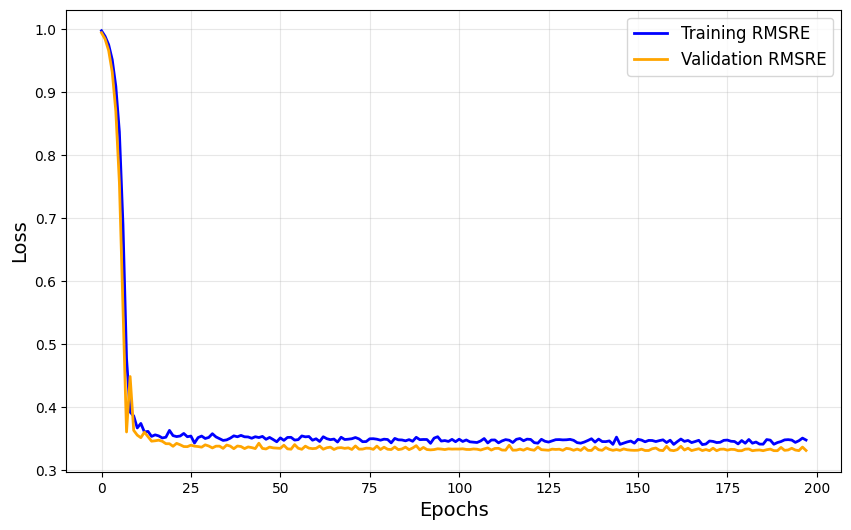

In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
class RMSRELoss(nn.Module):
    def __init__(self):
        super(RMSRELoss, self).__init__()

    def forward(self, predicted, target):
        epsilon = 1e-6
        relative_error = (predicted - target) / (target + epsilon)
        squared_relative_error = relative_error ** 2
        rmsre = torch.sqrt(torch.mean(squared_relative_error))
        return rmsre
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        attention_scores = self.attention_weights(x)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(attention_weights * x, dim=1)
        return weighted_sum
class MultimodalNetwork(nn.Module):
    def __init__(self):
        super(MultimodalNetwork, self).__init__()
        self.cgm_lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.cgm_lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.cgm_attention = Attention(128)

        self.cgm_dense = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, 64)
        )
        self.neural_dense = nn.Sequential(
            nn.Linear(50, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64)
        )
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2)
        )
        self.image_attention = Attention(128)
        self.image_dense = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64)
        )
        self.fc = nn.Sequential(
            nn.Linear(64+64+64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, cgm_input, neural_input, image_input):
        cgm_input = cgm_input.unsqueeze(-1)
        cgm_output, _ = self.cgm_lstm1(cgm_input)
        cgm_output, _ = self.cgm_lstm2(cgm_output)
        cgm_output = self.cgm_attention(cgm_output)
        cgm_output = self.cgm_dense(cgm_output)
        neural_output = self.neural_dense(neural_input)
        image_features = self.image_cnn(image_input)
        image_features = image_features.view(image_features.size(0), -1, 128)
        image_output = self.image_attention(image_features)
        image_output = self.image_dense(image_output)
        merged = torch.cat([cgm_output, neural_output, image_output], dim=1)
        output = self.fc(merged)
        return output

dataset = TensorDataset(x_cgm, x_neural, x_image, y_train) 
total_size = len(dataset)
train_size = int(0.8 * total_size)   
test_size = total_size - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) 
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

# Hyperparameters
learning_rate = 0.001
weight_decay = 1e-4
# dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
# learning_rates = [0.0001]
# weight_decays = [1e-4]
# learning_rates = [0.0001, 0.001, 0.01]
# weight_decays = [1e-4, 1e-5, 1e-3]
best_model = None
best_lr = None
best_wd = None
best_val_loss = float('inf')

for lr in learning_rates:
    for wd in weight_decays:
        print(f"Training with lr={lr} and weight_decay={wd}")
        model = MultimodalNetwork()
        criterion = RMSRELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        epochs = 400
        patience = 15
        best_val_loss = float('inf')
        patience_counter = 0

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(cgm_batch, neural_batch, image_batch)
                loss = criterion(outputs, target_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
                    outputs = model(cgm_batch, neural_batch, image_batch)
                    loss = criterion(outputs, target_batch)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break
            print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        model.load_state_dict(torch.load('best_model.pth'))

        if val_loss < best_val_loss:
            best_model = model
            best_lr = lr
            best_wd = wd
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training RMSRE', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation RMSRE', color='orange', linewidth=2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


Epoch 1/400, Training Loss: 0.9971, Validation Loss: 0.9921
Epoch 2/400, Training Loss: 0.9794, Validation Loss: 0.9472
Epoch 3/400, Training Loss: 0.6988, Validation Loss: 0.3777
Epoch 4/400, Training Loss: 0.3758, Validation Loss: 0.3152
Epoch 5/400, Training Loss: 0.3564, Validation Loss: 0.3180
Epoch 6/400, Training Loss: 0.3588, Validation Loss: 0.3303
Epoch 7/400, Training Loss: 0.3603, Validation Loss: 0.3192
Epoch 8/400, Training Loss: 0.3587, Validation Loss: 0.3231
Epoch 9/400, Training Loss: 0.3556, Validation Loss: 0.3150
Epoch 10/400, Training Loss: 0.3412, Validation Loss: 0.3169
Epoch 11/400, Training Loss: 0.3477, Validation Loss: 0.3166
Epoch 12/400, Training Loss: 0.3556, Validation Loss: 0.3182
Epoch 13/400, Training Loss: 0.3611, Validation Loss: 0.3170
Epoch 14/400, Training Loss: 0.3522, Validation Loss: 0.3152
Epoch 15/400, Training Loss: 0.3566, Validation Loss: 0.3155
Epoch 16/400, Training Loss: 0.3505, Validation Loss: 0.3157
Epoch 17/400, Training Loss: 0.34

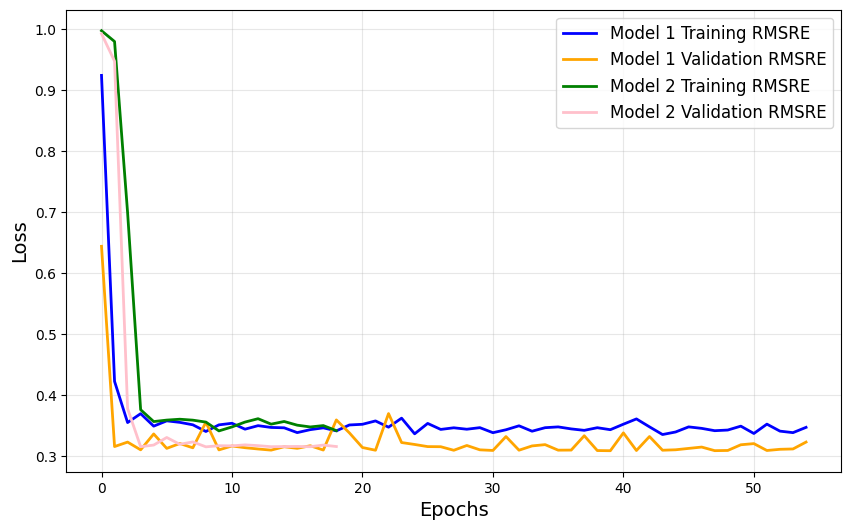

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt


# RMSRELoss remains the same
class RMSRELoss(nn.Module):
    def __init__(self):
        super(RMSRELoss, self).__init__()

    def forward(self, predicted, target):
        epsilon = 1e-6
        relative_error = (predicted - target) / (target + epsilon)
        squared_relative_error = relative_error ** 2
        rmsre = torch.sqrt(torch.mean(squared_relative_error))
        return rmsre


# Modified Attention class for uniformity
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        attention_scores = self.attention_weights(x)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(attention_weights * x, dim=1)
        return weighted_sum


class MultimodalNetworkWithEWC(nn.Module):
    def __init__(self):
        super(MultimodalNetworkWithEWC, self).__init__()
        self.cgm_lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.cgm_lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.cgm_attention = Attention(128)

        self.cgm_dense = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, 64)
        )
        self.neural_dense = nn.Sequential(
            nn.Linear(50, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64)
        )
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2)
        )
        self.image_attention = Attention(128)
        self.image_dense = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(64, 64),
            nn.Sigmoid(),
            nn.Dropout(0.3)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64 + 64, 64),
            nn.Sigmoid(),
            nn.Dropout(0.3)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(64 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Linear(64, 1)
        )

        self.apply(self.init_weights)

    def forward(self, cgm_input, neural_input, image_input):
        cgm_input = cgm_input.unsqueeze(-1)
        cgm_output, _ = self.cgm_lstm1(cgm_input)
        cgm_output, _ = self.cgm_lstm2(cgm_output)
        cgm_output = self.cgm_attention(cgm_output)
        cgm_output = self.cgm_dense(cgm_output)

        neural_output = self.neural_dense(neural_input)

        image_features = self.image_cnn(image_input)
        image_features = image_features.view(image_features.size(0), -1, 128)
        image_output = self.image_attention(image_features)
        image_output = self.image_dense(image_output)

        merged_fc1 = self.fc1(neural_output)
        merged_fc2_input = torch.cat([merged_fc1, image_output], dim=1)
        merged_fc2 = self.fc2(merged_fc2_input)
        merged_fc3_input = torch.cat([cgm_output, merged_fc2], dim=1)
        merged_fc3 = self.fc3(merged_fc3_input)

        return merged_fc3

    @staticmethod
    def init_weights(layer):
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)


# EWC Regularization
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.dataloader = dataloader
        self.criterion = criterion
        self.fisher = {}
        self.params = {name: p.clone().detach() for name, p in model.named_parameters() if p.requires_grad}
        self._compute_fisher()

    def _compute_fisher(self):
        self.model.eval()
        fisher = {name: torch.zeros_like(p) for name, p in self.params.items()}
        for inputs in self.dataloader:
            cgm_input, neural_input, image_input, target = inputs
            self.model.zero_grad()
            outputs = self.model(cgm_input, neural_input, image_input)
            loss = self.criterion(outputs, target)
            loss.backward()

            for name, p in self.model.named_parameters():
                if p.requires_grad:
                    fisher[name] += p.grad ** 2

        self.fisher = {name: p / len(self.dataloader) for name, p in fisher.items()}

    def penalty(self, model):
        loss = 0.0
        for name, p in model.named_parameters():
            if p.requires_grad:
                fisher_term = self.fisher[name]
                param_diff = p - self.params[name]
                loss += torch.sum(fisher_term * param_diff ** 2)
        return loss 
dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Define model, loss, optimizer
model2 =  MultimodalNetworkWithEWC()
criterion = RMSRELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
epochs = 400
patience = 10
best_val_loss2 = float('inf')
patience_counter = 0

train_losses2 = []
val_losses2 = []

for epoch in range(epochs):
    model2.train()
    train_loss2 = 0.0
    for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
        optimizer.zero_grad()
        outputs = model2(cgm_batch, neural_batch, image_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
        train_loss2 += loss.item()

    train_loss2 /= len(train_loader)
    train_losses2.append(train_loss2)

    model2.eval()
    val_loss2 = 0.0
    with torch.no_grad():
        for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
            outputs = model2(cgm_batch, neural_batch, image_batch)
            loss = criterion(outputs, target_batch)
            val_loss2 += loss.item()

    val_loss2 /= len(val_loader)
    val_losses2.append(val_loss2)

    if val_loss2 < best_val_loss2:
        best_val_loss2 = val_loss2
        patience_counter = 0
        torch.save(model2.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss2:.4f}, Validation Loss: {val_loss2:.4f}")

# Load the best model
model2.load_state_dict(torch.load('best_model.pth'))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Model 1 Training RMSRE', color='blue', linewidth=2)
plt.plot(val_losses, label='Model 1 Validation RMSRE', color='orange', linewidth=2)
plt.plot(train_losses2, label='Model 2 Training RMSRE', color='green', linewidth=2)
plt.plot(val_losses2, label='Model 2 Validation RMSRE', color='pink', linewidth=2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [63]:
pip install libauc

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


AUCMLoss is not found!
Epoch 1/400, Training Loss: 0.9996, Validation Loss: 0.9996
Epoch 2/400, Training Loss: 0.9995, Validation Loss: 0.9995
Epoch 3/400, Training Loss: 0.9994, Validation Loss: 0.9994
Epoch 4/400, Training Loss: 0.9993, Validation Loss: 0.9993
Epoch 5/400, Training Loss: 0.9993, Validation Loss: 0.9992
Epoch 6/400, Training Loss: 0.9992, Validation Loss: 0.9991
Epoch 7/400, Training Loss: 0.9991, Validation Loss: 0.9990
Epoch 8/400, Training Loss: 0.9990, Validation Loss: 0.9989
Epoch 9/400, Training Loss: 0.9989, Validation Loss: 0.9988
Epoch 10/400, Training Loss: 0.9989, Validation Loss: 0.9988
Epoch 11/400, Training Loss: 0.9988, Validation Loss: 0.9987
Epoch 12/400, Training Loss: 0.9987, Validation Loss: 0.9986
Epoch 13/400, Training Loss: 0.9986, Validation Loss: 0.9985
Epoch 14/400, Training Loss: 0.9985, Validation Loss: 0.9984
Epoch 15/400, Training Loss: 0.9985, Validation Loss: 0.9984
Epoch 16/400, Training Loss: 0.9984, Validation Loss: 0.9983
Epoch 17/4

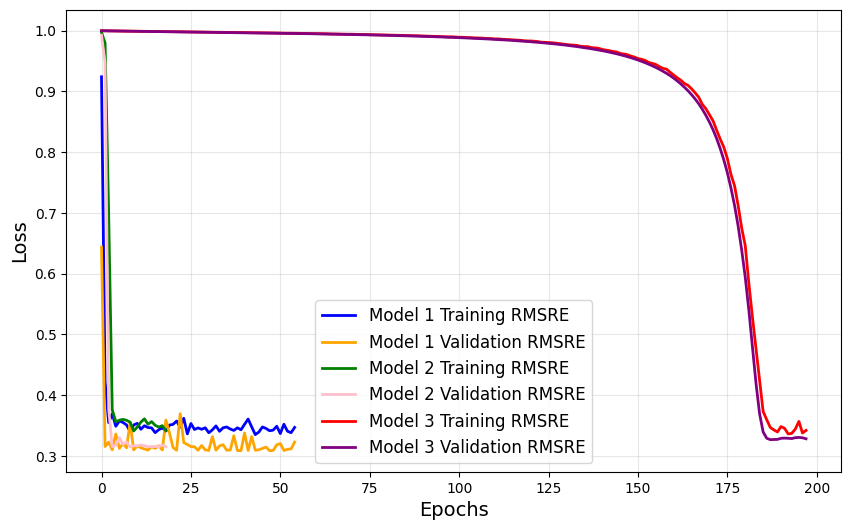

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from libauc.optimizers import PESG 
class RMSRELoss(nn.Module):
    def __init__(self):
        super(RMSRELoss, self).__init__()

    def forward(self, predicted, target):
        epsilon = 1e-6
        relative_error = (predicted - target) / (target + epsilon)
        squared_relative_error = relative_error ** 2
        rmsre = torch.sqrt(torch.mean(squared_relative_error))
        return rmsre 
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        attention_scores = self.attention_weights(x)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(attention_weights * x, dim=1)
        return weighted_sum


class MultimodalNetworkWithEWC(nn.Module):
    def __init__(self):
        super(MultimodalNetworkWithEWC, self).__init__()
        self.cgm_lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.cgm_lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.cgm_attention = Attention(128)

        self.cgm_dense = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            #nn.Dropout(0.7),
            nn.Linear(256, 64)
        )
        self.neural_dense = nn.Sequential(
            nn.Linear(50, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(256, 64)
        )
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #nn.Dropout2d(0.2)
        )
        self.image_attention = Attention(128)
        self.image_dense = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(256, 64)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(64, 64),
            nn.Sigmoid(),
            #nn.Dropout(0.3)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64 + 64, 64),
            nn.Sigmoid(),
            #nn.Dropout(0.3)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(64 + 64, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Linear(64, 1)
        )

        self.apply(self.init_weights)

    def forward(self, cgm_input, neural_input, image_input):
        cgm_input = cgm_input.unsqueeze(-1)
        cgm_output, _ = self.cgm_lstm1(cgm_input)
        cgm_output, _ = self.cgm_lstm2(cgm_output)
        cgm_output = self.cgm_attention(cgm_output)
        cgm_output = self.cgm_dense(cgm_output)

        neural_output = self.neural_dense(neural_input)

        image_features = self.image_cnn(image_input)
        image_features = image_features.view(image_features.size(0), -1, 128)
        image_output = self.image_attention(image_features)
        image_output = self.image_dense(image_output)

        merged_fc1 = self.fc1(neural_output)
        merged_fc2_input = torch.cat([merged_fc1, image_output], dim=1)
        merged_fc2 = self.fc2(merged_fc2_input)
        merged_fc3_input = torch.cat([cgm_output, merged_fc2], dim=1)
        merged_fc3 = self.fc3(merged_fc3_input)

        return merged_fc3

    @staticmethod
    def init_weights(layer):
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)


# EWC Regularization
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.dataloader = dataloader
        self.criterion = criterion
        self.fisher = {}
        self.params = {name: p.clone().detach() for name, p in model.named_parameters() if p.requires_grad}
        self._compute_fisher()

    def _compute_fisher(self):
        self.model.eval()
        fisher = {name: torch.zeros_like(p) for name, p in self.params.items()}
        for inputs in self.dataloader:
            cgm_input, neural_input, image_input, target = inputs
            self.model.zero_grad()
            outputs = self.model(cgm_input, neural_input, image_input)
            loss = self.criterion(outputs, target)
            loss.backward()

            for name, p in self.model.named_parameters():
                if p.requires_grad:
                    fisher[name] += p.grad ** 2

        self.fisher = {name: p / len(self.dataloader) for name, p in fisher.items()}

    def penalty(self, model):
        loss = 0.0
        for name, p in model.named_parameters():
            if p.requires_grad:
                fisher_term = self.fisher[name]
                param_diff = p - self.params[name]
                loss += torch.sum(fisher_term * param_diff ** 2)
        return loss


dataset = TensorDataset(x_cgm, x_neural, x_image, y_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False) 
model3 = MultimodalNetworkWithEWC()   
criterion = RMSRELoss()
epochs = 400
patience = 10
best_val_loss3 = float('inf')
patience_counter = 0

train_losses3 = []
val_losses3= []

# Initialize EWC for regularization
ewc = EWC(model3, train_loader, criterion)

optimizer = PESG(
    model3.parameters(),
    loss_fn=criterion,
    lr=0.01,
    a=0.01,
    b=1.0,
    alpha=1e-3,
    weight_decay=1e-5,
)

# Training loop with EWC regularization
for epoch in range(epochs):
    model3.train()
    train_loss3= 0.0
    for cgm_batch, neural_batch, image_batch, target_batch in train_loader:
        cgm_batch = cgm_batch.to(next(model3.parameters()).device) 
        neural_batch = neural_batch.to(next(model3.parameters()).device)
        image_batch = image_batch.to(next(model3.parameters()).device)
        target_batch = target_batch.to(next(model3.parameters()).device)
        optimizer.zero_grad()
        outputs = model3(cgm_batch, neural_batch, image_batch)
        loss = criterion(outputs, target_batch)
        
        # Adding EWC penalty
        ewc_penalty = ewc.penalty(model3)
        total_loss = loss + 0.01 * ewc_penalty  # Scale the penalty factor as needed

        total_loss.backward()
        optimizer.step()
        train_loss3 += total_loss.item()

    train_loss3 /= len(train_loader)
    train_losses3.append(train_loss3)

    # Validation
    model3.eval()
    val_loss3 = 0.0
    with torch.no_grad():
        for cgm_batch, neural_batch, image_batch, target_batch in val_loader:
            cgm_batch = cgm_batch.to(next(model3.parameters()).device) 
            neural_batch = neural_batch.to(next(model3.parameters()).device)
            image_batch = image_batch.to(next(model3.parameters()).device)
            target_batch = target_batch.to(next(model3.parameters()).device)
            outputs = model3(cgm_batch, neural_batch, image_batch)
            loss = criterion(outputs, target_batch)
            val_loss3 += loss.item()

    val_loss3 /= len(val_loader)
    val_losses3.append(val_loss3)

    # Save the best model
    if val_loss3 < best_val_loss3:
        best_val_loss3 = val_loss3
        patience_counter = 0
        torch.save(model3.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss3:.4f}, Validation Loss: {val_loss3:.4f}")

# Load and evaluate the best model
model3.load_state_dict(torch.load('best_model.pth'))


# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Model 1 Training RMSRE', color='blue', linewidth=2)
plt.plot(val_losses, label='Model 1 Validation RMSRE', color='orange', linewidth=2)
plt.plot(train_losses2, label='Model 2 Training RMSRE', color='green', linewidth=2)
plt.plot(val_losses2, label='Model 2 Validation RMSRE', color='pink', linewidth=2)
plt.plot(train_losses3, label='Model 3 Training RMSRE', color='red', linewidth=2)
plt.plot(val_losses3, label='Model 3 Validation RMSRE', color='purple', linewidth=2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [65]:

model.eval()
x_cgm_test = x_test[cgm_columns].values.astype(np.float32)
x_cgm_test_tensor = torch.tensor(x_cgm_test, dtype=torch.float32)
print(f"x_cgm_test_tensor shape: {x_cgm_test_tensor.shape}")
remaining_columns = [col for col in x_test.columns if col not in cgm_columns + [image_column]]
x_neural_test = x_test[remaining_columns].values.astype(np.float32)
x_neural_test_tensor = torch.tensor(x_neural_test, dtype=torch.float32)
x_image_test = np.stack(x_test[image_column].values) / 255.0
x_image_test_tensor = torch.tensor(x_image_test, dtype=torch.float32).view(30,3,64,64)
print(x_image_test_tensor.shape)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

with torch.no_grad():
    y_pred_tensor = model(x_cgm_test_tensor, x_neural_test_tensor, x_image_test_tensor)
y_pred = y_pred_tensor.numpy().flatten()
print("Predictions:", y_pred)
def rmsre(y_true, y_pred):
    relative_errors = (y_true - y_pred) / y_true
    squared_relative_errors = relative_errors ** 2
    mean_squared_relative_error = np.mean(squared_relative_errors)
    rmsre_value = np.sqrt(mean_squared_relative_error)
    return rmsre_value
rmsre_value = rmsre(y_test.values, y_pred)
print(f"RMSRE: {rmsre_value:.6f}")


x_cgm_test_tensor shape: torch.Size([30, 28])
torch.Size([30, 3, 64, 64])
Predictions: [390.50287 418.56467 450.3512  422.8869  400.94928 431.82028 444.3578
 397.9524  472.45514 409.52155 443.86496 452.71793 435.3632  444.65036
 426.26416 465.9979  424.59332 430.51697 450.4052  409.51996 466.1944
 424.3905  446.7666  450.81    421.6921  468.57465 419.47498 398.8266
 447.1422  478.8827 ]
RMSRE: 0.321881


In [66]:

model2.eval()
x_cgm_test = x_test[cgm_columns].values.astype(np.float32)
x_cgm_test_tensor = torch.tensor(x_cgm_test, dtype=torch.float32)
print(f"x_cgm_test_tensor shape: {x_cgm_test_tensor.shape}")
remaining_columns = [col for col in x_test.columns if col not in cgm_columns + [image_column]]
x_neural_test = x_test[remaining_columns].values.astype(np.float32)
x_neural_test_tensor = torch.tensor(x_neural_test, dtype=torch.float32)
x_image_test = np.stack(x_test[image_column].values) / 255.0
x_image_test_tensor = torch.tensor(x_image_test, dtype=torch.float32).view(30,3,64,64)
print(x_image_test_tensor.shape)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

with torch.no_grad():
    y_pred_tensor = model2(x_cgm_test_tensor, x_neural_test_tensor, x_image_test_tensor)
y_pred = y_pred_tensor.numpy().flatten()
print("Predictions:", y_pred)
def rmsre(y_true, y_pred):
    relative_errors = (y_true - y_pred) / y_true
    squared_relative_errors = relative_errors ** 2
    mean_squared_relative_error = np.mean(squared_relative_errors)
    rmsre_value = np.sqrt(mean_squared_relative_error)
    return rmsre_value
rmsre_value = rmsre(y_test.values, y_pred)
print(f"RMSRE: {rmsre_value:.6f}")


x_cgm_test_tensor shape: torch.Size([30, 28])
torch.Size([30, 3, 64, 64])
Predictions: [455.76538 471.67648 434.7792  451.57828 447.4121  441.19055 460.58923
 457.9094  434.098   444.63132 435.70218 437.6295  431.29224 445.00177
 454.02652 473.24313 427.3382  455.00372 441.9288  461.83475 461.25546
 444.25943 455.57816 465.85263 453.766   452.20212 441.73166 423.8218
 424.67786 458.0237 ]
RMSRE: 0.311346


In [67]:

model3.eval()
x_cgm_test = x_test[cgm_columns].values.astype(np.float32)
x_cgm_test_tensor = torch.tensor(x_cgm_test, dtype=torch.float32)
print(f"x_cgm_test_tensor shape: {x_cgm_test_tensor.shape}")
remaining_columns = [col for col in x_test.columns if col not in cgm_columns + [image_column]]
x_neural_test = x_test[remaining_columns].values.astype(np.float32)
x_neural_test_tensor = torch.tensor(x_neural_test, dtype=torch.float32)
x_image_test = np.stack(x_test[image_column].values) / 255.0
x_image_test_tensor = torch.tensor(x_image_test, dtype=torch.float32).view(30,3,64,64)
print(x_image_test_tensor.shape)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

with torch.no_grad():
    y_pred_tensor = model3(x_cgm_test_tensor, x_neural_test_tensor, x_image_test_tensor)
y_pred = y_pred_tensor.numpy().flatten()
print("Predictions:", y_pred)
def rmsre(y_true, y_pred):
    relative_errors = (y_true - y_pred) / y_true
    squared_relative_errors = relative_errors ** 2
    mean_squared_relative_error = np.mean(squared_relative_errors)
    rmsre_value = np.sqrt(mean_squared_relative_error)
    return rmsre_value
rmsre_value = rmsre(y_test.values, y_pred)
print(f"RMSRE: {rmsre_value:.6f}")


x_cgm_test_tensor shape: torch.Size([30, 28])
torch.Size([30, 3, 64, 64])
Predictions: [439.94785 440.49588 439.14508 439.93716 439.8725  439.56464 440.35483
 440.06784 439.1523  439.3029  439.43442 439.50903 439.30905 439.18607
 440.08203 440.61926 439.42798 440.12354 439.50082 440.28806 440.16443
 439.62326 440.07913 440.41095 439.99506 440.01648 439.6636  439.3732
 439.1661  440.09763]
RMSRE: 0.317527


In [68]:
cgm_test_dataframe = pd.read_csv('cgm_test.csv')
cgm_test_dataframe.head()

,Subject ID,Day,Breakfast Time,Lunch Time,CGM Data
0,4,2,2021-10-02 09:55:00,2021-10-02 13:46:00,"[('2021-10-02 09:55:00', 114.68333333333334), ..."
1,4,3,2021-10-03 09:53:00,2021-10-03 13:46:00,"[('2021-10-03 09:50:00', 103.0), ('2021-10-03 ..."
2,4,6,2021-10-06 09:04:00,2021-10-06 12:36:00,"[('2021-10-06 09:00:00', 96.41), ('2021-10-06 ..."
3,4,7,2021-10-07 08:56:00,2021-10-07 12:32:00,"[('2021-10-07 08:50:00', 95.0), ('2021-10-07 0..."
4,4,8,2021-10-08 09:09:00,2021-10-08 12:36:00,"[('2021-10-08 09:00:00', 94.13666666666667), (..."


In [69]:
cgm_test_dataframe.isnull().sum()

Subject ID        0
Day               0
Breakfast Time    0
Lunch Time        0
CGM Data          0
dtype: int64

In [70]:
cgm_test_dataframe['Lunch Time'] = pd.to_datetime(cgm_test_dataframe['Lunch Time'], errors='coerce')
cgm_test_dataframe['Lunch Time']= cgm_test_dataframe['Lunch Time'].dt.time
valid_times = cgm_test_dataframe['Lunch Time'].dropna()
valid_seconds = [t.hour * 3600 + t.minute * 60 + t.second for t in valid_times]
avg_seconds = int(np.mean(valid_seconds))
avg_time = pd.to_datetime(avg_seconds, unit='s').time()
cgm_test_dataframe['Lunch Time'] = cgm_test_dataframe['Lunch Time'].fillna(avg_time)

In [71]:
import ast
print(cgm_test_dataframe.shape)
cgm_test_dataframe['CGM Data'] = cgm_test_dataframe['CGM Data'].apply(ast.literal_eval)

(73, 5)


In [72]:
cgm_test_dataframe=cgm_test_dataframe.drop(['Breakfast Time'],axis=1)

In [73]:
cgm_test_dataframe = cgm_test_dataframe[cgm_test_dataframe['CGM Data'].apply(lambda x: len(x) > 0)]

In [74]:
cgm_test_dataframe.shape

(73, 4)

In [75]:
from datetime import datetime
for index, row in cgm_test_dataframe.iterrows():
    cgm_data_list = row['CGM Data']
    updated_cgm_data = [(datetime.strptime(item[0], "%Y-%m-%d %H:%M:%S").strftime("%H:%M:%S"), item[1]) for item in cgm_data_list]
    cgm_test_dataframe.at[index, 'CGM Data'] = updated_cgm_data

In [76]:
print(cgm_test_dataframe)

    Subject ID  Day Lunch Time  \
0            4    2   13:46:00   
1            4    3   13:46:00   
2            4    6   12:36:00   
3            4    7   12:32:00   
4            4    8   12:36:00   
..         ...  ...        ...   
68          18    5   13:39:53   
69          18    6   13:42:28   
70          18    7   14:57:13   
71          18    8   13:21:09   
72          18   10   13:11:54   

                                             CGM Data  
0   [(09:55:00, 114.68333333333334), (10:00:00, 12...  
1   [(09:50:00, 103.0), (09:55:00, 103.0), (10:00:...  
2   [(09:00:00, 96.41), (09:05:00, 99.683333333333...  
3   [(08:50:00, 95.0), (08:55:00, 95.41), (09:00:0...  
4   [(09:00:00, 94.13666666666667), (09:05:00, 95....  
..                                                ...  
68  [(08:25:00, 142.94), (08:30:00, 153.5366666666...  
69  [(09:15:00, 138.28333333333333), (09:20:00, 14...  
70  [(08:20:00, 138.65666666666667), (08:25:00, 14...  
71  [(08:50:00, 143.71666666666

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from datetime import datetime, timedelta
for index, row in cgm_test_dataframe.iterrows():
    cgm_data_list = row['CGM Data']
    updated_cgm_data = []
    for i in range(len(cgm_data_list)):
        time_str, value = cgm_data_list[i]
        time = datetime.strptime(time_str, "%H:%M:%S").time()
        updated_cgm_data.append((time, value))
    new_cgm_data = []
    if len(updated_cgm_data) > 0 :
      current_time = updated_cgm_data[0][0]
      current_value = updated_cgm_data[0][1]
      new_cgm_data.append((current_time, current_value))
      for i in range(1,len(updated_cgm_data)):
          next_time = updated_cgm_data[i][0]
          next_value = updated_cgm_data[i][1]
          time_diff = timedelta(hours=next_time.hour, minutes=next_time.minute, seconds=next_time.second) - timedelta(hours=current_time.hour, minutes=current_time.minute, seconds=current_time.second)
          if time_diff >= timedelta(minutes=5):
              while time_diff >= timedelta(minutes=5):
                  current_time = (datetime.combine(datetime.today(), current_time) + timedelta(minutes=5)).time()
                  avg_val = (current_value + next_value)/2
                  new_cgm_data.append((current_time, avg_val))
                  time_diff -= timedelta(minutes=5)
          new_cgm_data.append((next_time,next_value))
          current_time = next_time
          current_value = next_value

      cgm_test_dataframe.at[index, 'CGM Data'] = new_cgm_data
cgm_test_dataframe

,Subject ID,Day,Lunch Time,CGM Data
0,4,2,13:46:00,"[(09:55:00, 114.68333333333334), (10:00:00, 11..."
1,4,3,13:46:00,"[(09:50:00, 103.0), (09:55:00, 103.0), (09:55:..."
2,4,6,12:36:00,"[(09:00:00, 96.41), (09:05:00, 98.046666666666..."
3,4,7,12:32:00,"[(08:50:00, 95.0), (08:55:00, 95.205), (08:55:..."
4,4,8,12:36:00,"[(09:00:00, 94.13666666666667), (09:05:00, 94...."
...,...,...,...,...
68,18,5,13:39:53,"[(08:25:00, 142.94), (08:30:00, 148.2383333333..."
69,18,6,13:42:28,"[(09:15:00, 138.28333333333333), (09:20:00, 14..."
70,18,7,14:57:13,"[(08:20:00, 138.65666666666667), (08:25:00, 14..."
71,18,8,13:21:09,"[(08:50:00, 143.71666666666667), (08:55:00, 14..."


In [78]:
from scipy.signal import find_peaks
from scipy.integrate import simps
for index, row in cgm_test_dataframe.iterrows():
    lunch_time = row['Lunch Time']
    cgm_data_list = row['CGM Data']
    rounded_lunch_time = (datetime.combine(datetime.today(), lunch_time) +
                          timedelta(minutes=5 - lunch_time.minute % 5)).time()
    post_lunch_cgm = []
    for time_str, value in cgm_data_list:
        if isinstance(time_str, str):
            time = datetime.strptime(time_str, "%H:%M:%S").time()
        else:
            time = time_str
        if time >= rounded_lunch_time:
            post_lunch_cgm.append((time, value))
    if not post_lunch_cgm:
        post_lunch_cgm = cgm_data_list[-13:]
    cgm_values = [value for _, value in post_lunch_cgm]

    cgm_diff = np.diff(cgm_values).tolist()
    while len(cgm_diff) < 12:
        cgm_diff.append(np.nan)
    cgm_features = {}
    for i in range(12):
        cgm_features[f'cgm_diff{i+1}'] = cgm_diff[i]


    if len(cgm_diff) > 0 and not all(np.isnan(cgm_diff)):
        diff_mean = np.nanmean(cgm_diff)
        diff_max = np.nanmax(cgm_diff)
        diff_min = np.nanmin(cgm_diff)
        diff_std = np.nanstd(cgm_diff)
        diff_median = np.nanmedian(cgm_diff)
        diff_range = diff_max - diff_min
        diff_iqr = np.percentile(cgm_diff, 75) - np.percentile(cgm_diff, 25)
        diff_variance = np.nanvar(cgm_diff)
    else:
        diff_mean = diff_max = diff_min = diff_std = diff_median = diff_range = diff_iqr = diff_variance = np.nan


    if post_lunch_cgm:
        times = [datetime.strptime(str(t), "%H:%M:%S").time() for t, _ in post_lunch_cgm]
        values = [v for _, v in post_lunch_cgm]
        time_to_peak = (datetime.combine(datetime.today(), max(times)) -
                        datetime.combine(datetime.today(), rounded_lunch_time)).seconds / 60.0
        time_to_trough = (datetime.combine(datetime.today(), min(times)) -
                          datetime.combine(datetime.today(), rounded_lunch_time)).seconds / 60.0
    else:
        time_to_peak = time_to_trough = np.nan


    rate_of_change = np.gradient(cgm_values).tolist() if cgm_values else []
    max_rate_of_change = max(rate_of_change) if rate_of_change else np.nan
    min_rate_of_change = min(rate_of_change) if rate_of_change else np.nan


    peaks, _ = find_peaks(cgm_values)
    troughs, _ = find_peaks([-v for v in cgm_values])
    peak_count = len(peaks)
    trough_count = len(troughs)
    peak_to_peak_diff = max(cgm_values) - min(cgm_values) if cgm_values else np.nan


    auc = simps(cgm_values) if cgm_values else np.nan  # Area Under Curve (AUC)

    # # Threshold-based features
    # hyper_events = sum(1 for v in cgm_values if v > 180)
    # hypo_events = sum(1 for v in cgm_values if v < 70)
    # time_above_threshold = sum(1 for t, v in post_lunch_cgm if v > 180)
    # time_below_threshold = sum(1 for t, v in post_lunch_cgm if v < 70)


    for feature_name, feature_value in cgm_features.items():
        cgm_test_dataframe.loc[index, feature_name] = feature_value


    cgm_test_dataframe.loc[index, 'diff_mean'] = diff_mean
    cgm_test_dataframe.loc[index, 'diff_max'] = diff_max
    cgm_test_dataframe.loc[index, 'diff_min'] = diff_min
    cgm_test_dataframe.loc[index, 'diff_std'] = diff_std
    cgm_test_dataframe.loc[index, 'diff_median'] = diff_median
    cgm_test_dataframe.loc[index, 'diff_range'] = diff_range
    cgm_test_dataframe.loc[index, 'diff_iqr'] = diff_iqr
    cgm_test_dataframe.loc[index, 'diff_variance'] = diff_variance
    cgm_test_dataframe.loc[index, 'time_to_peak'] = time_to_peak
    cgm_test_dataframe.loc[index, 'time_to_trough'] = time_to_trough
    cgm_test_dataframe.loc[index, 'max_rate_of_change'] = max_rate_of_change
    cgm_test_dataframe.loc[index, 'min_rate_of_change'] = min_rate_of_change
    cgm_test_dataframe.loc[index, 'peak_count'] = peak_count
    cgm_test_dataframe.loc[index, 'trough_count'] = trough_count
    cgm_test_dataframe.loc[index, 'peak_to_peak_diff'] = peak_to_peak_diff
    cgm_test_dataframe.loc[index, 'auc'] = auc

In [79]:
print(cgm_test_dataframe)
print(cgm_test_dataframe.shape)

    Subject ID  Day Lunch Time  \
0            4    2   13:46:00   
1            4    3   13:46:00   
2            4    6   12:36:00   
3            4    7   12:32:00   
4            4    8   12:36:00   
..         ...  ...        ...   
68          18    5   13:39:53   
69          18    6   13:42:28   
70          18    7   14:57:13   
71          18    8   13:21:09   
72          18   10   13:11:54   

                                             CGM Data  cgm_diff1  cgm_diff2  \
0   [(09:55:00, 114.68333333333334), (10:00:00, 11...   8.158333   5.658333   
1   [(09:50:00, 103.0), (09:55:00, 103.0), (09:55:...   1.000000   0.795000   
2   [(09:00:00, 96.41), (09:05:00, 98.046666666666...   0.410000   3.341667   
3   [(08:50:00, 95.0), (08:55:00, 95.205), (08:55:...   0.205000   1.978333   
4   [(09:00:00, 94.13666666666667), (09:05:00, 94....   0.568333   0.863333   
..                                                ...        ...        ...   
68  [(08:25:00, 142.94), (08:30:00, 14

In [80]:
cgm_test_dataframe['Lunch Time'] = cgm_test_dataframe['Lunch Time'].apply(lambda x: x.hour * 60 + x.minute)
cgm_test_dataframe.head()

,Subject ID,Day,Lunch Time,CGM Data,cgm_diff1,cgm_diff2,cgm_diff3,cgm_diff4,cgm_diff5,cgm_diff6,...,diff_iqr,diff_variance,time_to_peak,time_to_trough,max_rate_of_change,min_rate_of_change,peak_count,trough_count,peak_to_peak_diff,auc
0,4,2,826,"[(09:55:00, 114.68333333333334), (10:00:00, 11...",8.158333,5.658333,5.658333,3.431667,3.431667,2.863333,...,3.136667,5.950823,220.0,0.0,8.158333,-4.658333,5.0,4.0,62.136667,10438.490556
1,4,3,826,"[(09:50:00, 103.0), (09:55:00, 103.0), (09:55:...",1.000000,0.795000,0.795000,-0.431667,-0.431667,0.205000,...,0.863333,2.803604,230.0,0.0,6.931667,-1.295000,6.0,5.0,64.726667,9825.426667
2,4,6,756,"[(09:00:00, 96.41), (09:05:00, 98.046666666666...",0.410000,3.341667,3.341667,5.158333,5.158333,3.000000,...,2.295000,2.773992,225.0,0.0,5.158333,-2.000000,3.0,3.0,47.453333,10886.907500
3,4,7,752,"[(08:50:00, 95.0), (08:55:00, 95.205), (08:55:...",0.205000,1.978333,1.978333,4.658333,4.658333,2.226667,...,2.352500,2.765488,235.0,0.0,4.658333,-2.726667,2.0,1.0,57.795000,11484.735000
4,4,8,756,"[(09:00:00, 94.13666666666667), (09:05:00, 94....",0.568333,0.863333,0.863333,0.068333,0.068333,0.431667,...,1.000000,0.565453,225.0,0.0,2.726667,-0.931667,3.0,3.0,36.431667,8976.060556


In [81]:
cgm_test_dataframe.isnull().sum()

Subject ID            0
Day                   0
Lunch Time            0
CGM Data              0
cgm_diff1             0
cgm_diff2             0
cgm_diff3             0
cgm_diff4             0
cgm_diff5             0
cgm_diff6             0
cgm_diff7             0
cgm_diff8             0
cgm_diff9             0
cgm_diff10            0
cgm_diff11            0
cgm_diff12            0
diff_mean             0
diff_max              0
diff_min              0
diff_std              0
diff_median           0
diff_range            0
diff_iqr              0
diff_variance         0
time_to_peak          0
time_to_trough        0
max_rate_of_change    0
min_rate_of_change    0
peak_count            0
trough_count          0
peak_to_peak_diff     0
auc                   0
dtype: int64

In [82]:
cgm_test_dataframe.shape

(73, 32)

In [83]:
cgm_test_dataframe=cgm_test_dataframe.drop(['CGM Data'],axis=1)


In [84]:
demo_viome_test_dataframe = pd.read_csv('demo_viome_test.csv')
demo_viome_test_dataframe.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,4,33,1,262.6,66.0,Hispanic/Latino,1,5.5,105.0,19.4,300.0,267.0,46.0,221.0,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919..."
1,21,63,1,142.6,62.5,African American,1,5.3,98.0,9.3,63.0,178.0,51.0,127.0,115.0,13.0,3.5,2.25037,25.663437,"0.9132611196203955,5.118312363484425,0.7490546..."
2,27,24,1,173.2,67.0,Hispanic/Latino,1,4.7,90.0,6.3,40.0,134.0,57.0,77.0,67.0,8.0,2.4,1.40000,27.123992,"44.5262736442813,-9.295344245726843,0.14686137..."
3,34,24,0,185.0,71.0,White,1,4.6,80.0,4.2,104.0,161.0,61.0,100.0,81.0,21.0,2.6,0.82963,25.799445,"-0.16622831775986097,9.301906171641043,-0.3511..."
4,39,45,1,147.2,62.0,Hispanic/Latino,3,8.3,158.0,17.5,177.0,145.0,38.0,107.0,77.0,35.0,3.8,6.82716,26.920291,"0.6403789380570297,7.722202301019041,-0.651212..."


In [85]:
img_test_dataframe = pd.read_csv('img_test.csv')
img_test_dataframe.head()
mean_fiber_breakfast = img_test_dataframe['Breakfast Fiber'].mean()
print(mean_fiber_breakfast)
img_test_dataframe.fillna({'Breakfast Fiber': mean_fiber_breakfast}, inplace=True)

0.6805555555555556


In [86]:
label_test_breakfast_only_dataframe = pd.read_csv('label_test_breakfast_only.csv')
label_test_breakfast_only_dataframe.head()

,Subject ID,Day,Breakfast Calories,Breakfast Carbs,Breakfast Fat,Breakfast Protein
0,4,2,448.0,66.0,10.5,22.0
1,4,3,608.0,66.0,10.5,66.0
2,4,6,268.0,24.0,10.5,22.0
3,4,7,448.0,66.0,10.5,22.0
4,4,8,608.0,66.0,10.5,66.0


In [87]:
img_test_cgm_test_dataframe = pd.merge(img_test_dataframe, cgm_test_dataframe, on=['Day','Subject ID'])
img_test_cgm_test_dataframe.head()

,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Lunch Time,cgm_diff1,cgm_diff2,cgm_diff3,...,diff_iqr,diff_variance,time_to_peak,time_to_trough,max_rate_of_change,min_rate_of_change,peak_count,trough_count,peak_to_peak_diff,auc
0,4,2,0.0,10,"[[[55, 75, 29], [55, 77, 27], [53, 76, 24], [5...","[[[37, 42, 28], [36, 40, 25], [24, 31, 17], [7...",826,8.158333,5.658333,5.658333,...,3.136667,5.950823,220.0,0.0,8.158333,-4.658333,5.0,4.0,62.136667,10438.490556
1,4,3,0.0,4,"[[[56, 170, 210], [100, 189, 216], [140, 217, ...","[[[29, 34, 32], [29, 33, 32], [28, 31, 30], [2...",826,1.000000,0.795000,0.795000,...,0.863333,2.803604,230.0,0.0,6.931667,-1.295000,6.0,5.0,64.726667,9825.426667
2,4,6,0.0,18,"[[[227, 153, 39], [219, 145, 33], [211, 136, 3...","[[[55, 35, 29], [64, 29, 26], [71, 41, 43], [6...",756,0.410000,3.341667,3.341667,...,2.295000,2.773992,225.0,0.0,5.158333,-2.000000,3.0,3.0,47.453333,10886.907500
3,4,7,0.0,10,"[[[146, 192, 146], [145, 192, 148], [142, 189,...","[[[110, 108, 108], [115, 113, 115], [126, 123,...",752,0.205000,1.978333,1.978333,...,2.352500,2.765488,235.0,0.0,4.658333,-2.726667,2.0,1.0,57.795000,11484.735000
4,4,8,0.0,4,"[[[201, 239, 155], [208, 242, 156], [211, 242,...","[[[88, 87, 100], [95, 95, 107], [89, 90, 100],...",756,0.568333,0.863333,0.863333,...,1.000000,0.565453,225.0,0.0,2.726667,-0.931667,3.0,3.0,36.431667,8976.060556


In [88]:
img_test_cgm_test_dataframe_demo_viome_dataframe= pd.merge(img_test_cgm_test_dataframe, demo_viome_test_dataframe, on='Subject ID')
img_test_cgm_test_dataframe_demo_viome_dataframe.head()

,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Lunch Time,cgm_diff1,cgm_diff2,cgm_diff3,...,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,4,2,0.0,10,"[[[55, 75, 29], [55, 77, 27], [53, 76, 24], [5...","[[[37, 42, 28], [36, 40, 25], [24, 31, 17], [7...",826,8.158333,5.658333,5.658333,...,300.0,267.0,46.0,221.0,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919..."
1,4,3,0.0,4,"[[[56, 170, 210], [100, 189, 216], [140, 217, ...","[[[29, 34, 32], [29, 33, 32], [28, 31, 30], [2...",826,1.000000,0.795000,0.795000,...,300.0,267.0,46.0,221.0,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919..."
2,4,6,0.0,18,"[[[227, 153, 39], [219, 145, 33], [211, 136, 3...","[[[55, 35, 29], [64, 29, 26], [71, 41, 43], [6...",756,0.410000,3.341667,3.341667,...,300.0,267.0,46.0,221.0,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919..."
3,4,7,0.0,10,"[[[146, 192, 146], [145, 192, 148], [142, 189,...","[[[110, 108, 108], [115, 113, 115], [126, 123,...",752,0.205000,1.978333,1.978333,...,300.0,267.0,46.0,221.0,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919..."
4,4,8,0.0,4,"[[[201, 239, 155], [208, 242, 156], [211, 242,...","[[[88, 87, 100], [95, 95, 107], [89, 90, 100],...",756,0.568333,0.863333,0.863333,...,300.0,267.0,46.0,221.0,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919..."


In [89]:
print(img_test_cgm_test_dataframe_demo_viome_dataframe.isnull().sum())

Subject ID                  0
Day                         0
Breakfast Fiber             0
Lunch Fiber                 0
Image Before Breakfast      0
Image Before Lunch          0
Lunch Time                  0
cgm_diff1                   0
cgm_diff2                   0
cgm_diff3                   0
cgm_diff4                   0
cgm_diff5                   0
cgm_diff6                   0
cgm_diff7                   0
cgm_diff8                   0
cgm_diff9                   0
cgm_diff10                  0
cgm_diff11                  0
cgm_diff12                  0
diff_mean                   0
diff_max                    0
diff_min                    0
diff_std                    0
diff_median                 0
diff_range                  0
diff_iqr                    0
diff_variance               0
time_to_peak                0
time_to_trough              0
max_rate_of_change          0
min_rate_of_change          0
peak_count                  0
trough_count                0
peak_to_pe

In [90]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe= pd.merge(img_test_cgm_test_dataframe_demo_viome_dataframe, label_test_breakfast_only_dataframe, on=['Day','Subject ID'])

In [91]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.head()

,Subject ID,Day,Breakfast Fiber,Lunch Fiber,Image Before Breakfast,Image Before Lunch,Lunch Time,cgm_diff1,cgm_diff2,cgm_diff3,...,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome,Breakfast Calories,Breakfast Carbs,Breakfast Fat,Breakfast Protein
0,4,2,0.0,10,"[[[55, 75, 29], [55, 77, 27], [53, 76, 24], [5...","[[[37, 42, 28], [36, 40, 25], [24, 31, 17], [7...",826,8.158333,5.658333,5.658333,...,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919...",448.0,66.0,10.5,22.0
1,4,3,0.0,4,"[[[56, 170, 210], [100, 189, 216], [140, 217, ...","[[[29, 34, 32], [29, 33, 32], [28, 31, 30], [2...",826,1.000000,0.795000,0.795000,...,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919...",608.0,66.0,10.5,66.0
2,4,6,0.0,18,"[[[227, 153, 39], [219, 145, 33], [211, 136, 3...","[[[55, 35, 29], [64, 29, 26], [71, 41, 43], [6...",756,0.410000,3.341667,3.341667,...,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919...",268.0,24.0,10.5,22.0
3,4,7,0.0,10,"[[[146, 192, 146], [145, 192, 148], [142, 189,...","[[[110, 108, 108], [115, 113, 115], [126, 123,...",752,0.205000,1.978333,1.978333,...,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919...",448.0,66.0,10.5,22.0
4,4,8,0.0,4,"[[[201, 239, 155], [208, 242, 156], [211, 242,...","[[[88, 87, 100], [95, 95, 107], [89, 90, 100],...",756,0.568333,0.863333,0.863333,...,164.0,60.0,5.8,5.02963,42.380119,"-8.159737251015637,-6.592865703640219,2.144919...",608.0,66.0,10.5,66.0


In [92]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.shape

(73, 58)

In [93]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.columns

Index(['Subject ID', 'Day', 'Breakfast Fiber', 'Lunch Fiber',
       'Image Before Breakfast', 'Image Before Lunch', 'Lunch Time',
       'cgm_diff1', 'cgm_diff2', 'cgm_diff3', 'cgm_diff4', 'cgm_diff5',
       'cgm_diff6', 'cgm_diff7', 'cgm_diff8', 'cgm_diff9', 'cgm_diff10',
       'cgm_diff11', 'cgm_diff12', 'diff_mean', 'diff_max', 'diff_min',
       'diff_std', 'diff_median', 'diff_range', 'diff_iqr', 'diff_variance',
       'time_to_peak', 'time_to_trough', 'max_rate_of_change',
       'min_rate_of_change', 'peak_count', 'trough_count', 'peak_to_peak_diff',
       'auc', 'Age', 'Gender', 'Weight', 'Height', 'Race', 'Diabetes Status',
       'A1C', 'Baseline Fasting Glucose', 'Insulin', 'Triglycerides',
       'Cholesterol', 'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio',
       'HOMA-IR', 'BMI', 'Viome', 'Breakfast Calories', 'Breakfast Carbs',
       'Breakfast Fat', 'Breakfast Protein'],
      dtype='object')

In [94]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.drop(['Subject ID','Day','Image Before Breakfast','Breakfast Carbs', 'Breakfast Fat', 'Breakfast Protein','Breakfast Calories'],axis=1,inplace=True)

In [95]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.shape

(73, 51)

In [96]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_split'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome'].apply(lambda x: [float(i) for i in x.split(',')] if isinstance(x, str) else [])
print(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[['Viome', 'Viome_split']].head())
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_empty'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_split'].apply(lambda x: len(x) == 0)
print(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[['Viome', 'Viome_empty']].head())
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_mean'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_split'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_std'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_split'].apply(lambda x: np.std(x) if len(x) > 0 else np.nan)
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_min'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_split'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_max'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_split'].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)
print(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']].head())
for i in range(27):  # Assuming you know there are 27 values in the list
    img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[f'Viome_value_{i+1}'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Viome_split'].apply(lambda x: x[i] if len(x) > i else np.nan)
print(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[[f'Viome_value_{i+1}' for i in range(27)]].head())

                                               Viome  \
0  -8.159737251015637,-6.592865703640219,2.144919...   
1  -8.159737251015637,-6.592865703640219,2.144919...   
2  -8.159737251015637,-6.592865703640219,2.144919...   
3  -8.159737251015637,-6.592865703640219,2.144919...   
4  -8.159737251015637,-6.592865703640219,2.144919...   

                                         Viome_split  
0  [-8.159737251015637, -6.592865703640219, 2.144...  
1  [-8.159737251015637, -6.592865703640219, 2.144...  
2  [-8.159737251015637, -6.592865703640219, 2.144...  
3  [-8.159737251015637, -6.592865703640219, 2.144...  
4  [-8.159737251015637, -6.592865703640219, 2.144...  
                                               Viome  Viome_empty
0  -8.159737251015637,-6.592865703640219,2.144919...        False
1  -8.159737251015637,-6.592865703640219,2.144919...        False
2  -8.159737251015637,-6.592865703640219,2.144919...        False
3  -8.159737251015637,-6.592865703640219,2.144919...        False
4  

In [97]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']].apply(pd.to_numeric, errors='coerce')
#img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']] = x_test[['Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max']].apply(pd.to_numeric, errors='coerce')
for i in range(27):
    img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[f'Viome_value_{i+1}'] = pd.to_numeric(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[f'Viome_value_{i+1}'], errors='coerce')



In [98]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Race'] = encoder.fit_transform(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Race'])

In [99]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.drop(['Viome_empty','Viome','Viome_split','Lunch Fiber','Breakfast Fiber'],axis=1,inplace=True)

In [100]:
print(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.dtypes)

Image Before Lunch     object
Lunch Time              int64
cgm_diff1             float64
cgm_diff2             float64
cgm_diff3             float64
                       ...   
Viome_value_23        float64
Viome_value_24        float64
Viome_value_25        float64
Viome_value_26        float64
Viome_value_27        float64
Length: 79, dtype: object


In [101]:
print(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.shape)

(73, 79)


In [102]:
print(img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.columns)

Index(['Image Before Lunch', 'Lunch Time', 'cgm_diff1', 'cgm_diff2',
       'cgm_diff3', 'cgm_diff4', 'cgm_diff5', 'cgm_diff6', 'cgm_diff7',
       'cgm_diff8', 'cgm_diff9', 'cgm_diff10', 'cgm_diff11', 'cgm_diff12',
       'diff_mean', 'diff_max', 'diff_min', 'diff_std', 'diff_median',
       'diff_range', 'diff_iqr', 'diff_variance', 'time_to_peak',
       'time_to_trough', 'max_rate_of_change', 'min_rate_of_change',
       'peak_count', 'trough_count', 'peak_to_peak_diff', 'auc', 'Age',
       'Gender', 'Weight', 'Height', 'Race', 'Diabetes Status', 'A1C',
       'Baseline Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol',
       'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI',
       'Viome_mean', 'Viome_std', 'Viome_min', 'Viome_max', 'Viome_value_1',
       'Viome_value_2', 'Viome_value_3', 'Viome_value_4', 'Viome_value_5',
       'Viome_value_6', 'Viome_value_7', 'Viome_value_8', 'Viome_value_9',
       'Viome_value_10', 'Viome_value_11', 'Viome_value

In [103]:
img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Image Before Lunch'] = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe['Image Before Lunch'].apply(ast.literal_eval)

test_x_cgm = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[cgm_columns].values.astype(np.float32)
test_x_image = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[image_column]
test_x_image = np.array(test_x_image.tolist(), dtype=np.float32) / 255.0
remaining_columns = [col for col in img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe.columns if col not in cgm_columns+ [image_column]]
test_x_neural = img_label_cgm_demo_viome_dataframe_label_test_breakfast_only_dataframe[remaining_columns].values.astype(np.float32)

In [104]:
print("Type of x_cgm:", type(x_cgm), "Shape:", np.shape(test_x_cgm))
print("Type of x_neural:", type(x_neural), "Shape:", np.shape(test_x_neural))
print("Type of x_image:", type(x_image), "Shape:", np.shape(test_x_image))
test_x_cgm = torch.tensor(test_x_cgm, dtype=torch.float32)
test_x_neural = torch.tensor(test_x_neural, dtype=torch.float32)
test_x_image = torch.tensor(test_x_image, dtype=torch.float32).view(73,3,64,64)

Type of x_cgm: <class 'torch.Tensor'> Shape: (73, 28)
Type of x_neural: <class 'torch.Tensor'> Shape: (73, 50)
Type of x_image: <class 'torch.Tensor'> Shape: (73, 64, 64, 3)


In [105]:
model.eval()
with torch.no_grad():
    test_outputs = model(test_x_cgm, test_x_neural, test_x_image)

In [106]:
model2.eval()
with torch.no_grad():
    test_outputs2 = model2(test_x_cgm, test_x_neural, test_x_image) 

In [107]:
model3.eval()
with torch.no_grad():
    test_outputs3 = model3(test_x_cgm, test_x_neural, test_x_image) 

In [108]:
print(test_outputs.shape)

torch.Size([73, 1])


In [109]:
test_outputs  = test_outputs.numpy().flatten()
test_outputs2  = test_outputs2.numpy().flatten()
test_outputs3  = test_outputs3.numpy().flatten()



In [110]:
print(test_outputs)

[472.15454 472.15454 441.4907  439.73965 441.4907  507.13394 463.38867
 420.6488  421.48822 525.2795  439.2043  419.81342 380.9288  425.28418
 437.93854 437.0948  424.83722 444.64883 495.1341  458.14056 451.17712
 455.09406 435.9445  420.5658  446.82492 411.9162  447.79883 416.98193
 426.2693  415.71548 445.266   471.15152 411.07208 413.83798 418.5495
 407.8415  400.9883  426.25928 406.12817 406.12817 394.1352  411.69635
 454.89346 453.62222 448.10925 451.5019  448.10925 447.26114 451.9259
 488.91714 452.34998 471.4237  426.98456 431.20752 439.73544 457.6924
 441.86978 419.01477 434.26562 443.6144  418.1676  443.6144  443.6144
 417.32037 401.649   457.99045 450.89917 443.39075 453.8191  455.0705
 486.5192  446.31067 442.13937]


In [111]:
results_test_df = pd.DataFrame({
    'row_id': range(0, len(test_outputs)),
    'label': test_outputs
})
results_test_df.to_csv('predictions.csv', index=False)
print(results_test_df.head())

   row_id       label
0       0  472.154541
1       1  472.154541
2       2  441.490692
3       3  439.739655
4       4  441.490692


In [112]:
table1_unique = label_dataframe.drop_duplicates(subset=["Day"])
merged_table = pd.merge(label_test_breakfast_only_dataframe, table1_unique[["Day", "Lunch Calories"]],
                        on="Day", how="left")
merged_table.head()

,Subject ID,Day,Breakfast Calories,Breakfast Carbs,Breakfast Fat,Breakfast Protein,Lunch Calories
0,4,2,448.0,66.0,10.5,22.0,830
1,4,3,608.0,66.0,10.5,66.0,435
2,4,6,268.0,24.0,10.5,22.0,1180
3,4,7,448.0,66.0,10.5,22.0,830
4,4,8,608.0,66.0,10.5,66.0,435


In [113]:
lunCal = merged_table['Lunch Calories']
print(lunCal)

0      830
1      435
2     1180
3      830
4      435
      ... 
68     355
69    1180
70     830
71     435
72     355
Name: Lunch Calories, Length: 73, dtype: int64


In [114]:
loss = rmsre(lunCal, test_outputs)
print(loss)

0.33794256535426587


In [115]:
loss2 = rmsre(lunCal, test_outputs2)
print(loss2)

0.3348816138324098


In [116]:
loss3 = rmsre(lunCal, test_outputs3)
print(loss3)

0.3368634901712732
